Objectiu o problema que es vol resoldre: Tractar de predir on es cometrà un delicte o número de delictes per un any. Classificar delictes per zona?

Llistat de funcions que farem servir per netejar el dataset

In [26]:
from sklearn.datasets import make_regression
import numpy as np
import pandas as pd
%matplotlib notebook
from matplotlib import pyplot as plt
import scipy.stats
import seaborn as sns
from IPython.display import display, HTML

def datasetReplace(ds):
    ds = ds.replace("%", "", regex=True)
    ds = ds.replace(",", "", regex=True)
    return ds

def nullCounter(ds):
    print(ds.isnull().sum())
    print(ds.shape)
    
def printColumnTypes(ds):
    for line in ds.columns:
        print(line, type(ds[line][0]))
    print("-------------------------------------------------------")
    print(ds.shape)
    
# Visualitzarem només 3 decimals per mostra
pd.set_option('display.float_format', lambda x: '%.3f' % x)

pd.set_option('display.max_columns', None)
# Funcio per a llegir dades en format csv
def load_dataset(path):
    dataset = pd.read_csv(path, header=0, delimiter=',', error_bad_lines=False)
    return dataset

def printColumnValues(ds):
    columns = ds.columns
    for col in columns:
        print(col ," values: ", ds[col].unique())
        print("---------------------------------------------------------------------------------------------")

In [14]:
# Carreguem 4 datasets, més endevant unirem tots i agafarem un nombre X de files per treballar
crimeC2001To2004 = load_dataset("data/Chicago_Crimes_2001_to_2004.csv")

crimeC2005To2007 = load_dataset("data/Chicago_Crimes_2005_to_2007.csv")

crimeC2008To2011 = load_dataset("data/Chicago_Crimes_2008_to_2011.csv")

crimeC2012To2017 = load_dataset("data/Chicago_Crimes_2012_to_2017.csv")

# Fusionem els 4 datasets en un sol

frames = [crimeC2001To2004, crimeC2005To2007, crimeC2008To2011, crimeC2012To2017]

crimeC = pd.concat(frames)

display(HTML(crimeC[50:70].to_html()))
nullCounter(crimeC)

print("Dimensionalitat de la BBDD:", crimeC.shape)

C:\Users\adria\AppData\Local\Temp\ipykernel_7920\2881515587.py:31: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  dataset = pd.read_csv(path, header=0, delimiter=',', error_bad_lines=False)
b'Skipping line 1513591: expected 23 fields, saw 24\n'
C:\Users\adria\AppData\Local\Temp\ipykernel_7920\2881515587.py:31: DtypeWarning: Columns (17,20) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(path, header=0, delimiter=',', error_bad_lines=False)
C:\Users\adria\AppData\Local\Temp\ipykernel_7920\2881515587.py:31: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  dataset = pd.read_csv(path, header=0, delimiter=',', error_bad_lines=False)
b'Skipping line 533719: expected 23 fields, saw 24\n'
C:\Users\adria\AppData\Local\Temp\ipykernel_7920\2881515587.py:31: FutureW

Unnamed: 0                   0
ID                           0
Case Number                  7
Date                         0
Block                        0
IUCR                         0
Primary Type                 0
Description                  0
Location Description      1990
Arrest                       0
Domestic                     0
Beat                         0
District                    91
Ward                    700224
Community Area          702091
FBI Code                     0
X Coordinate            105573
Y Coordinate            105573
Year                         0
Updated On                   0
Latitude                105573
Longitude               105574
Location                105574
dtype: int64
(7941282, 23)
Dimensionalitat de la BBDD: (7941282, 23)


Explicació dels atributs de la Base de dades:
- ID: Identificador únic per al registre.
- Case Number: Identificador únic per a un incident.
- Date: Data en la que va ocorrer el incident. A vegades pot set una estimació.
- Block: Direcció parcial(suposem per motius de privacitat,etc.) del lloc del incident.
- IUCR: Illinois Uniform Reporting Code. Está relacionat deirectament amb Primary Type i Description.
- Primary Type: Descripció principal del codi IUCR.
- Description: Descripció secundària del codi IUCR. Subcategoria de Primary Type.
- Location Description: Descripció de l'ubicació on va ocorrer l'incident.
- Arrest: Booleà que indica si va haver-hi un arrest o no.
- Domestic: Booleà que indica si l'incident està relacionat amb violència domèstica.
- Beat: Indica el beat(barrio?) on va ocorrer l'incident. Un beat és l'àrea geogràfica policial més petita.
- District: Indica el districte policial on va ocorrer l'incident.
- Ward: Districte del ajuntament on el incident va ocorrer.
- Community Area: Indica el àrea de comunitat on va ocorrer l'incident. Chicago té 77 d'aquestes àrees.
- FBI Code: Indica la classificació del delicte com es descriu en el FBI's National Incident-Based Reporting System (NIBRS).
- X Coordinate: La coordenada X de la ubicació on va ocorrer l'incident. Aquesta es mou de la ubicació real per a la redacció parcial, però cau al mateix Block.
- Y Coordinate: La coordenada Y de la ubicació on va ocorrer l'incident. Aquesta es mou de la ubicació real per a la redacció parcial, però cau al mateix Block.
- Year: Any en que va ocorrer l'incident.
- Updated On: Data i hora en que es va actualitzar el registre per últim cop.
- Latitude: La latitud on va ocorrer l'incident. Aquesta ubicació es mou de la real per a la redacció parcial, però cau en el mateix Block.
- Longitude: La longitud on va ocorrer l'incident.Aquesta ubicació es mou de la real per a la redacció parcial, però cau en el mateix Block.
- Location: Ubicació on va ocorrer l'incident en un format que permet la creació de mapes i altres operacions geogràfiques. Aquesta ubicació es mou de la real per a la redacció parcial, però cau en el mateix Block.

In [15]:
oldCrimeCShapeX = crimeC.shape[0]
print("Dimensionalitat X: ", oldCrimeCShapeX)

Dimensionalitat X:  7941282


Eliminem valors NaN directament, ja que la columna amb més nuls en té 700k que tampoc representa un gran problema tenint en compte el volum de dades que tenim de 7M de files. A més a més segurament acabaré agafant un subset de les dades ja que no tinc la capacitat de comput del superordinador del MareNostrum.

In [16]:
crimeC = crimeC.dropna()
crimeC = crimeC.drop(['Unnamed: 0'], axis=1)
nullCounter(crimeC)

ID                      0
Case Number             0
Date                    0
Block                   0
IUCR                    0
Primary Type            0
Description             0
Location Description    0
Arrest                  0
Domestic                0
Beat                    0
District                0
Ward                    0
Community Area          0
FBI Code                0
X Coordinate            0
Y Coordinate            0
Year                    0
Updated On              0
Latitude                0
Longitude               0
Location                0
dtype: int64
(7145213, 22)


In [17]:
newCrimeCShapeX = crimeC.shape[0]
print("Dimensionalitat X: ", newCrimeCShapeX)

print("Percentatge d'eliminats: ", (1-(newCrimeCShapeX/oldCrimeCShapeX))*100,"%")

Dimensionalitat X:  7145213
Percentatge d'eliminats:  10.024439378931515 %


Comprovo si n'hi han files duplicades

In [18]:
crimeC.drop_duplicates(subset=['ID', 'Case Number'], inplace=True)
crimeC.shape

(5478329, 22)

In [19]:
print("Percentatge d'eliminats sense duplicats: ", (1-(crimeC.shape[0]/oldCrimeCShapeX))*100,"%")

Percentatge d'eliminats sense duplicats:  31.01455155477415 %


In [20]:
crimeC.to_csv("data/Chicago_Crimes_2001_to_2017.csv", index=False)

Veure el tipus de dada per a cada columna

In [21]:
crimeC = load_dataset("data/Chicago_Crimes_2001_to_2017.csv")

C:\Users\adria\AppData\Local\Temp\ipykernel_7920\2881515587.py:31: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  dataset = pd.read_csv(path, header=0, delimiter=',', error_bad_lines=False)


In [22]:
printColumnTypes(crimeC)

ID <class 'numpy.int64'>
Case Number <class 'str'>
Date <class 'str'>
Block <class 'str'>
IUCR <class 'str'>
Primary Type <class 'str'>
Description <class 'str'>
Location Description <class 'str'>
Arrest <class 'numpy.bool_'>
Domestic <class 'numpy.bool_'>
Beat <class 'numpy.int64'>
District <class 'numpy.float64'>
Ward <class 'numpy.float64'>
Community Area <class 'numpy.float64'>
FBI Code <class 'str'>
X Coordinate <class 'numpy.float64'>
Y Coordinate <class 'numpy.float64'>
Year <class 'numpy.float64'>
Updated On <class 'str'>
Latitude <class 'numpy.float64'>
Longitude <class 'numpy.float64'>
Location <class 'str'>
-------------------------------------------------------
(5478329, 22)


El següent pas a fer serà passar els atributs categòrics o no numèrics a valors numèrics. També s'eliminaràn les columnes que no serveixen per aconseguir l'objectiu.

In [27]:
printColumnValues(crimeC)

ID  values:  [ 4676906  4677901  4791194 ... 10508681 10508690 10508692]
---------------------------------------------------------------------------------------------
Case Number  values:  ['HM278933' 'HM275615' 'HM403711' ... 'HZ250479' 'HZ250370' 'HZ250517']
---------------------------------------------------------------------------------------------
Date  values:  ['03/01/2003 12:00:00 AM' '05/01/2003 01:00:00 AM'
 '01/01/2001 11:00:00 AM' ... '05/03/2016 11:28:00 PM'
 '05/03/2016 11:33:00 PM' '05/03/2016 09:07:00 PM']
---------------------------------------------------------------------------------------------
Block  values:  ['004XX W 42ND PL' '111XX S NORMAL AVE' '114XX S ST LAWRENCE AVE' ...
 '030XX W Carroll Ave' '061XX S Oak Park Ave' '000XX W 79TH ST']
---------------------------------------------------------------------------------------------
IUCR  values:  ['2825' '0841' '0266' '5007' '0840' '1753' '1754' '0910' '0810' '1563'
 '1150' '0842' '1130' '1752' '0281' '1562' '500

Location Description  values:  ['RESIDENCE' 'RESIDENCE PORCH/HALLWAY' 'APARTMENT' 'OTHER' 'GAS STATION'
 'COMMERCIAL / BUSINESS OFFICE' 'STREET' 'BANK' 'APPLIANCE STORE'
 'PARKING LOT/GARAGE(NON.RESID.)' 'CHURCH/SYNAGOGUE/PLACE OF WORSHIP'
 'DAY CARE CENTER' 'HOSPITAL BUILDING/GROUNDS' 'HOTEL/MOTEL'
 'SCHOOL, PRIVATE, GROUNDS' 'VEHICLE NON-COMMERCIAL' 'ALLEY'
 'SMALL RETAIL STORE' 'DEPARTMENT STORE' 'RESTAURANT'
 'MEDICAL/DENTAL OFFICE' 'CHA STAIRWELL' 'AUTO' 'RETAIL STORE' 'TAVERN'
 'GAS STATION DRIVE/PROP.' 'HALLWAY' 'TRUCK' 'GANGWAY' 'PARKING LOT'
 'FACTORY/MANUFACTURING BUILDING' 'HOUSE' 'COACH HOUSE' 'PORCH' 'CLUB'
 'SCHOOL, PUBLIC, BUILDING' 'BASEMENT' 'VACANT LOT' 'YARD' 'SIDEWALK'
 'AIRPORT BUILDING NON-TERMINAL - SECURE AREA' 'CHA APARTMENT' 'CAR WASH'
 'LOADING DOCK' 'CHA ELEVATOR' 'VESTIBULE' 'CHA HALLWAY'
 'GOVERNMENT BUILDING/PROPERTY'
 'AIRPORT TERMINAL UPPER LEVEL - SECURE AREA' 'GARAGE'
 'ABANDONED BUILDING' 'PARK PROPERTY' 'RAILROAD PROPERTY' 'CHA PLAY LOT'
 'CHA GROUN

Passem la data a un format que comprengui python

In [32]:
crimeC['Date'] = pd.to_datetime(crimeC['Date'], format='%m/%d/%Y %I:%M:%S %p')

Esborrem les columnes que a priori no ens serviran de gaire

In [34]:
crimeC = crimeC.drop(['Case Number', 'IUCR', 'Updated On', 'FBI Code'], axis=1)

0         2003-03-01 00:00:00
1         2003-05-01 01:00:00
2         2001-01-01 11:00:00
3         2003-03-15 00:00:00
4         2003-01-01 00:00:00
                  ...        
5478324   2016-05-03 23:33:00
5478325   2016-05-03 23:30:00
5478326   2016-05-03 00:15:00
5478327   2016-05-03 21:07:00
5478328   2016-05-03 23:38:00
Name: Date, Length: 5478329, dtype: datetime64[ns]

In [ ]:
for i in range(len(crimeC['Location'])):
    crimeC['Latitude'] = crimeC['Location'][i][1:13].astype('float64')
    crimeC['Longitude'] = crimeC['Location'][i][15:27].astype('float64')

In [63]:
printColumnTypes(crimeC)

5478329

In [12]:
#Esborrar els valors nulls que queden, si falta més del 50% esborrem la colummna, sino fem mitja o posem 0's.
#Buscar valors nulls a les columnes
print("POUNDS GRADED: ",datasetBeef.loc[datasetBeef['POUNDS GRADED'].isnull().values])
print("%  of FEDERAL  SLAUGHTER\t BEEF: ",datasetBeef.loc[datasetBeef['%  of FEDERAL  SLAUGHTER\t BEEF'].isnull().values])
print("PRIME: ", datasetBeef.loc[datasetBeef['PRIME'].isnull().values])
print("CHOICE: ",datasetBeef.loc[datasetBeef['CHOICE'].isnull().values])
print("SELECT: ",datasetBeef.loc[datasetBeef['SELECT'].isnull().values])
print("UTILITY",datasetBeef.loc[datasetBeef['UTILITY'].isnull().values])

#Esborrar fila 1982 completament nula, ja  que només és una fila i fer la mitja no sería representatiu
datasetBeef = datasetBeef.loc[datasetBeef['YEAR'] != 1982]
datasetBeef = datasetBeef.reset_index()
nullCounter(datasetBeef)

datasetBeef = datasetBeef.drop(['index'], axis=1)
beefDrop, beefFill = columnSelector(datasetBeef)

datasetBeef.drop(columns=beefDrop, inplace=True) ##Eliminem les columnes

###Trying sklearn
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

dfFill0 = datasetBeef.copy(deep=True)
dfFillMean= datasetBeef.copy(deep=True)

print(datasetBeef.describe())

imputer = KNNImputer()
dfnew = datasetBeef.copy(deep=True)

print(dfnew.describe())

for key in beefFill:
    print("key", key)
    X = [datasetBeef[key].values]
    x_guess = imputer.fit_transform(dfnew[key].reset_index())
    dfnew[key] = [v[1] for v in x_guess]

for key in beefFill:
    mn = datasetBeef[key].mean()##Omplim amb la mitja
    dfFillMean[key] = dfFillMean[key].fillna(mn)
    
for key in beefFill:
    dfFill0[key] = dfFill0[key].fillna(0)
print("-------------------------------------------------------")


dfnew.describe()

POUNDS GRADED:      YEAR  POUNDS GRADED  PRIME  CHOICE  SELECT  STNDRD  COMRCL  UTILITY  \
34  1982            NaN    NaN     NaN     NaN     NaN     NaN      NaN   

    CUTTER  CANNER  S/H  %  of FEDERAL  SLAUGHTER\t BEEF  
34     NaN     NaN  NaN                              NaN  
%  of FEDERAL  SLAUGHTER	 BEEF:      YEAR  POUNDS GRADED  PRIME  CHOICE  SELECT  STNDRD  COMRCL  UTILITY  \
34  1982            NaN    NaN     NaN     NaN     NaN     NaN      NaN   

    CUTTER  CANNER  S/H  %  of FEDERAL  SLAUGHTER\t BEEF  
34     NaN     NaN  NaN                              NaN  
PRIME:      YEAR  POUNDS GRADED  PRIME   CHOICE   SELECT  STNDRD   COMRCL  UTILITY  \
4   1942       1478.000    NaN  439.000  560.000     NaN  284.000  173.000   
5   1943       6691.000    NaN 1297.000 2081.000     NaN 1544.000  984.000   
6   1944       8328.000    NaN  865.000 2329.000     NaN 2104.000 1560.000   
7   1945       9067.000    NaN 1258.000 2791.000     NaN 2421.000 1506.000   
8   1946       

YEAR  POUNDS GRADED    PRIME    CHOICE   SELECT  STNDRD   COMRCL  \
count   67.000         67.000   67.000    67.000   67.000  67.000   67.000   
mean  1979.552      13127.582  504.979  8749.836 3205.522  79.170  156.033   
std     22.628       6186.194  299.630  4176.600 2795.323  81.542  471.525   
min   1938.000        509.000    6.000   230.000  176.000   1.000    1.000   
25%   1962.500       8697.500  287.500  5594.500 1108.000   7.000    2.000   
50%   1981.000      12729.000  473.000 10800.000 1776.000  49.000   15.000   
75%   1998.500      19722.000  717.000 11588.500 6153.000 179.000   55.000   
max   2015.000      23720.000 1369.000 13409.000 8279.000 263.000 2421.000   

       UTILITY   CUTTER  %  of FEDERAL  SLAUGHTER\t BEEF  
count   67.000   67.000                           67.000  
mean   146.651   74.140                           63.740  
std    299.095  245.641                           21.059  
min      1.000    1.000                            7.500  
25%     10.500    2.200                           53.650  
50%     34.000    4.000                           63.700  
75%    153.000   23.500                           81.750  
max   1560.000 1470.000                           94.900

Printem els valors nulls per cada dataset per veure si realment no queda cap NaN

In [13]:
nullCounter(dfnew)
print("-------------")
nullCounter(dfFill0)
print("-------------")
nullCounter(dfFillMean)

for line in dfFillMean.columns:
    print(line, type(dfFillMean[line][0]))
    

YEAR                               0
POUNDS GRADED                      0
PRIME                              0
CHOICE                             0
SELECT                             0
STNDRD                             0
COMRCL                             0
UTILITY                            0
CUTTER                             0
%  of FEDERAL  SLAUGHTER\t BEEF    0
dtype: int64
(67, 10)
-------------
YEAR                               0
POUNDS GRADED                      0
PRIME                              0
CHOICE                             0
SELECT                             0
STNDRD                             0
COMRCL                             0
UTILITY                            0
CUTTER                             0
%  of FEDERAL  SLAUGHTER\t BEEF    0
dtype: int64
(67, 10)
-------------
YEAR                               0
POUNDS GRADED                      0
PRIME                              0
CHOICE                             0
SELECT                             0
STN

In [14]:
dfFillMean.describe()

YEAR  POUNDS GRADED    PRIME    CHOICE   SELECT  STNDRD   COMRCL  \
count   67.000         67.000   67.000    67.000   67.000  67.000   67.000   
mean  1979.552      13127.582  536.129  8749.836 3205.522  61.648  165.825   
std     22.628       6186.194  277.464  4176.600 2795.323  64.308  469.896   
min   1938.000        509.000    6.000   230.000  176.000   1.000    1.000   
25%   1962.500       8697.500  349.000  5594.500 1108.000   8.500    2.500   
50%   1981.000      12729.000  536.129 10800.000 1776.000  58.000   33.000   
75%   1998.500      19722.000  717.000 11588.500 6153.000  71.000   63.000   
max   2015.000      23720.000 1369.000 13409.000 8279.000 263.000 2421.000   

       UTILITY   CUTTER  %  of FEDERAL  SLAUGHTER\t BEEF  
count   67.000   67.000                           67.000  
mean   151.062  122.700                           63.740  
std    298.020  238.313                           21.059  
min      1.000    1.000                            7.500  
25%     11.500   12.000                           53.650  
50%     43.000   74.000                           63.700  
75%    153.531  122.700                           81.750  
max   1560.000 1470.000                           94.900

In [15]:
dfFill0.describe()

YEAR  POUNDS GRADED    PRIME    CHOICE   SELECT  STNDRD   COMRCL  \
count   67.000         67.000   67.000    67.000   67.000  67.000   67.000   
mean  1979.552      13127.582  496.119  8749.836 3205.522  49.687  155.925   
std     22.628       6186.194  311.668  4176.600 2795.323  68.840  471.561   
min   1938.000        509.000    0.000   230.000  176.000   0.000    0.000   
25%   1962.500       8697.500  287.500  5594.500 1108.000   1.000    1.500   
50%   1981.000      12729.000  473.000 10800.000 1776.000  12.000   15.000   
75%   1998.500      19722.000  717.000 11588.500 6153.000  71.000   55.000   
max   2015.000      23720.000 1369.000 13409.000 8279.000 263.000 2421.000   

       UTILITY   CUTTER  %  of FEDERAL  SLAUGHTER\t BEEF  
count   67.000   67.000                           67.000  
mean   146.552   73.254                           63.740  
std    299.144  245.906                           21.059  
min      0.000    0.000                            7.500  
25%     10.500    0.000                           53.650  
50%     34.000    4.000                           63.700  
75%    153.000   23.500                           81.750  
max   1560.000 1470.000                           94.900

In [16]:
dfnew.describe()

YEAR  POUNDS GRADED    PRIME    CHOICE   SELECT  STNDRD   COMRCL  \
count   67.000         67.000   67.000    67.000   67.000  67.000   67.000   
mean  1979.552      13127.582  504.979  8749.836 3205.522  79.170  156.033   
std     22.628       6186.194  299.630  4176.600 2795.323  81.542  471.525   
min   1938.000        509.000    6.000   230.000  176.000   1.000    1.000   
25%   1962.500       8697.500  287.500  5594.500 1108.000   7.000    2.000   
50%   1981.000      12729.000  473.000 10800.000 1776.000  49.000   15.000   
75%   1998.500      19722.000  717.000 11588.500 6153.000 179.000   55.000   
max   2015.000      23720.000 1369.000 13409.000 8279.000 263.000 2421.000   

       UTILITY   CUTTER  %  of FEDERAL  SLAUGHTER\t BEEF  
count   67.000   67.000                           67.000  
mean   146.651   74.140                           63.740  
std    299.095  245.641                           21.059  
min      1.000    1.000                            7.500  
25%     10.500    2.200                           53.650  
50%     34.000    4.000                           63.700  
75%    153.000   23.500                           81.750  
max   1560.000 1470.000                           94.900

Fem gràfics per veure els resultats d'omplir els NaN segons l'estratègia utilitzada

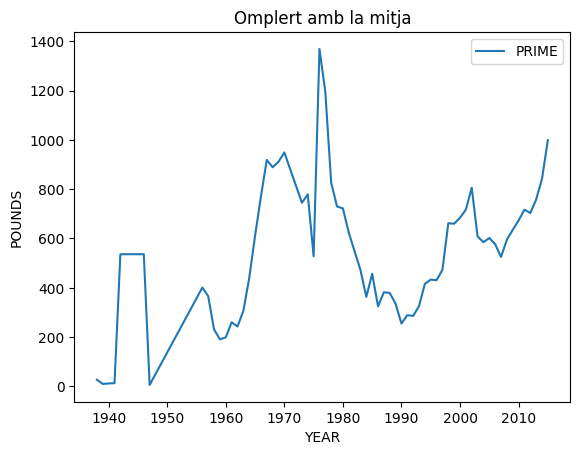

In [17]:
plf = dfFillMean.plot(x = 'YEAR', y = 'PRIME', title='Omplert amb la mitja')
plf.set_ylabel("POUNDS")
plf.get_figure().savefig('images/meanPlot')

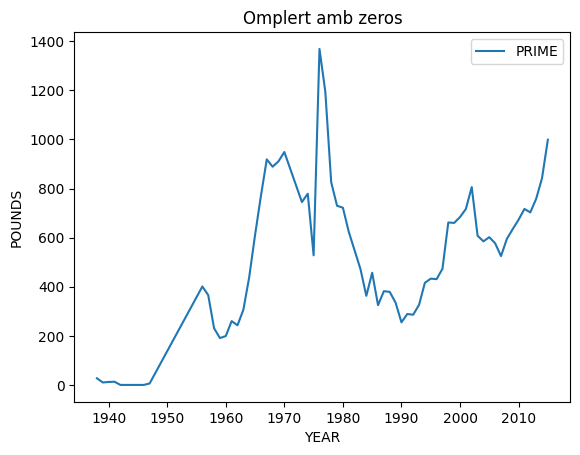

In [18]:
plf = dfFill0.plot(x = 'YEAR', y = 'PRIME', title='Omplert amb zeros')
plf.set_ylabel("POUNDS")
plf.get_figure().savefig('images/fill0Plot')

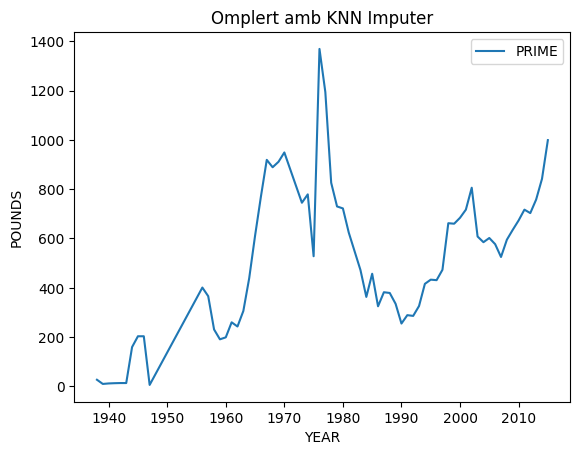

In [19]:
plf = dfnew.plot(x = 'YEAR', y = 'PRIME', title='Omplert amb KNN Imputer')
plf.set_ylabel("POUNDS")
plf.get_figure().savefig('images/knnPlot')

<AxesSubplot: xlabel='YEAR'>

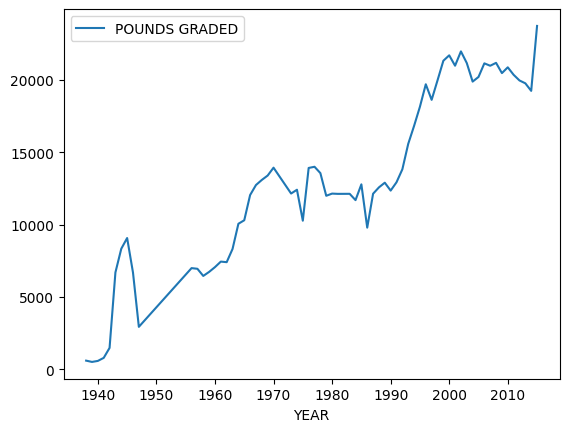

In [20]:
dfnew.plot(x = 'YEAR', y = 'POUNDS GRADED')

Per cada dataset fem una suma de totes les columnes de tipus de carn de cara a fer la regressió sobre pounds graded.

In [21]:
lista = ['PRIME', 'CHOICE', 'SELECT', 'STNDRD', 'COMRCL', 'UTILITY', 'CUTTER']
dfFill0['SUM'] = dfFill0[lista].sum(axis=1)
dfFill0[40:68]

YEAR  POUNDS GRADED   PRIME    CHOICE   SELECT  STNDRD  COMRCL  UTILITY  \
40  1989      12890.000 335.000 11105.000 1433.000   1.000   1.000   11.000   
41  1990      12345.000 255.000 10172.000 1906.000   0.000   1.000   11.000   
42  1991      12919.000 289.000 10193.000 2427.000   0.000   1.000    9.000   
43  1992      13816.000 286.000 10315.000 3203.000   4.000   1.000    7.000   
44  1993      15572.000 326.000 10377.000 4846.000   8.000   3.000   12.000   
45  1994      16813.000 416.000 10895.000 5481.000   2.000   1.000   18.000   
46  1995      18139.000 433.000 11276.000 6414.000   1.000   1.000   13.000   
47  1996      19689.000 431.000 10964.000 6735.000   1.000   1.000    7.000   
48  1997      18614.000 473.000 10906.000 7228.000   1.000   1.000    6.000   
49  1998      19955.000 662.000 11912.000 7374.000   1.000   1.000    6.000   
50  1999      21314.000 660.000 11901.000 7880.000   2.000   0.000    5.000   
51  2000      21689.000 684.000 11906.000 8199.000   1.000   1.000    5.000   
52  2001      20972.000 717.000 11503.000 7909.000   1.000   1.000    2.000   
53  2002      21961.000 806.000 12334.000 8004.000   0.000   0.000    0.000   
54  2003      21155.000 608.000 11580.000 8108.000   9.000   0.000    0.000   
55  2004      19874.000 585.000 10986.000 7458.000  80.000   1.000    1.000   
56  2005      20193.000 602.000 11133.000 7679.000  29.000   3.000    3.000   
57  2006      21134.000 577.000 11367.000 8279.000   6.000   3.000    6.000   
58  2007      20969.000 525.000 11655.000 7872.000  56.000   2.000   10.000   
59  2008      21169.000 595.000 12459.000 7312.000  70.000   2.000    7.000   
60  2009      20460.000 635.000 12725.000 6524.000  49.000   2.000    9.000   
61  2010      20860.000 673.000 13126.000 6416.000 132.000   3.000   14.000   
62  2011      20342.000 717.000 13170.000 6204.000  68.000   3.000   16.000   
63  2012      19952.000 703.000 12889.000 6102.000  63.000   3.000   15.000   
64  2013      19755.000 758.000 13038.000 5788.000  11.000   4.000   16.000   
65  2014      19234.000 842.000 13157.000 5067.000   8.000   4.000   18.000   
66  2015      23720.000 999.000 13409.000 3971.000   3.000   3.000   19.000   

    CUTTER  %  of FEDERAL  SLAUGHTER\t BEEF       SUM  
40   3.000                           66.900 12889.000  
41   0.000                           74.300 12345.000  
42   0.000                           79.800 12919.000  
43   0.000                           84.500 13816.000  
44   0.000                           81.300 15572.000  
45   0.000                           81.900 16813.000  
46   0.000                           82.200 18138.000  
47   0.000                           81.100 18139.000  
48   1.000                           82.000 18616.000  
49   0.000                           83.200 19956.000  
50   0.000                           83.500 20448.000  
51   0.000                           84.000 20796.000  
52   0.000                           83.000 20133.000  
53   0.000                           83.800 21144.000  
54   0.000                           82.200 20305.000  
55   0.000                           83.700 19111.000  
56   0.000                           84.100 19449.000  
57   0.000                           83.600 20238.000  
58   0.000                           82.000 20120.000  
59   0.000                           81.600 20445.000  
60   0.000                           80.200 19944.000  
61   0.000                           82.000 20364.000  
62   0.000                           80.100 20178.000  
63   0.000                           79.700 19775.000  
64   0.000                           79.700 19615.000  
65   0.000                           80.900 19096.000  
66   0.000                           80.900 18404.000

In [22]:
lista = ['PRIME', 'CHOICE', 'SELECT', 'STNDRD', 'COMRCL', 'UTILITY', 'CUTTER']
dfFillMean['SUM'] = dfFillMean[lista].sum(axis=1)
dfFillMean

YEAR  POUNDS GRADED   PRIME    CHOICE   SELECT  STNDRD  COMRCL  UTILITY  \
0   1938        598.000  27.000   283.000  187.000  61.648  54.000   34.000   
1   1939        509.000  10.000   232.000  176.000  61.648  55.000   29.000   
2   1940        579.000  12.000   230.000  234.000  61.648  69.000   25.000   
3   1941        789.000  13.000   308.000  344.000  61.648  86.000   26.000   
4   1942       1478.000 536.129   439.000  560.000  61.648 284.000  173.000   
..   ...            ...     ...       ...      ...     ...     ...      ...   
62  2011      20342.000 717.000 13170.000 6204.000  68.000   3.000   16.000   
63  2012      19952.000 703.000 12889.000 6102.000  63.000   3.000   15.000   
64  2013      19755.000 758.000 13038.000 5788.000  11.000   4.000   16.000   
65  2014      19234.000 842.000 13157.000 5067.000   8.000   4.000   18.000   
66  2015      23720.000 999.000 13409.000 3971.000   3.000   3.000   19.000   

    CUTTER  %  of FEDERAL  SLAUGHTER\t BEEF       SUM  
0   11.000                            9.000   657.648  
1    6.000                            7.500   569.648  
2    7.000                            8.300   638.648  
3    9.000                           10.100   847.648  
4   15.000                           17.300  2068.777  
..     ...                              ...       ...  
62 122.700                           80.100 20300.700  
63 122.700                           79.700 19897.700  
64 122.700                           79.700 19737.700  
65 122.700                           80.900 19218.700  
66 122.700                           80.900 18526.700  

[67 rows x 11 columns]

In [23]:
lista = ['PRIME', 'CHOICE', 'SELECT', 'STNDRD', 'COMRCL', 'UTILITY', 'CUTTER']
dfnew['SUM'] = dfnew[lista].sum(axis=1)
dfnew

YEAR  POUNDS GRADED   PRIME    CHOICE   SELECT  STNDRD  COMRCL  \
0  1938.000        598.000  27.000   283.000  187.000 195.000  54.000   
1  1939.000        509.000  10.000   232.000  176.000 195.000  55.000   
2  1940.000        579.000  12.000   230.000  234.000 195.000  69.000   
3  1941.000        789.000  13.000   308.000  344.000 195.000  86.000   
4  1942.000       1478.000  13.600   439.000  560.000 195.000 284.000   
..      ...            ...     ...       ...      ...     ...     ...   
62 2011.000      20342.000 717.000 13170.000 6204.000  68.000   3.000   
63 2012.000      19952.000 703.000 12889.000 6102.000  63.000   3.000   
64 2013.000      19755.000 758.000 13038.000 5788.000  11.000   4.000   
65 2014.000      19234.000 842.000 13157.000 5067.000   8.000   4.000   
66 2015.000      23720.000 999.000 13409.000 3971.000   3.000   3.000   

    UTILITY  CUTTER  %  of FEDERAL  SLAUGHTER\t BEEF       SUM  
0    34.000  11.000                            9.000   791.000  
1    29.000   6.000                            7.500   703.000  
2    25.000   7.000                            8.300   772.000  
3    26.000   9.000                           10.100   981.000  
4   173.000  15.000                           17.300  1679.600  
..      ...     ...                              ...       ...  
62   16.000   2.200                           80.100 20180.200  
63   15.000   2.200                           79.700 19777.200  
64   16.000   2.200                           79.700 19617.200  
65   18.000   2.200                           80.900 19098.200  
66   19.000   2.200                           80.900 18406.200  

[67 rows x 11 columns]

(67, 11)
Index(['YEAR', 'POUNDS GRADED', 'PRIME', 'CHOICE', 'SELECT', 'STNDRD',
       'COMRCL', 'UTILITY', 'CUTTER', '%  of FEDERAL  SLAUGHTER\t BEEF',
       'SUM'],
      dtype='object')


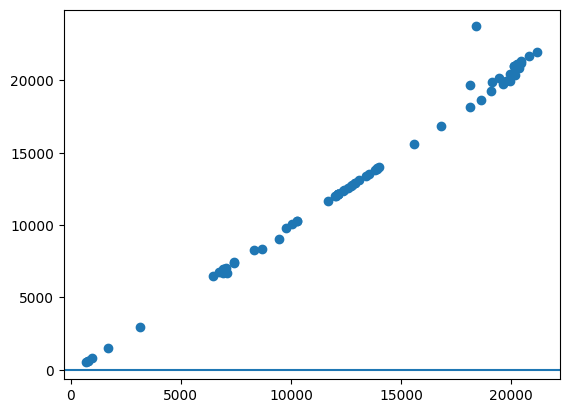

In [24]:
dataBeef = dfnew.values
print(dfnew.shape)
x = dataBeef[:69, 0:12]
y = dataBeef[:80, 1]
index = dfFill0.columns[:13]

plt.figure()
ax = plt.scatter(x[:,10], y)
plt.axhline(y=-0.5, xmin=0.0, xmax=1.0)

print(index)

In [25]:
dfnew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   YEAR                            67 non-null     float64
 1   POUNDS GRADED                   67 non-null     float64
 2   PRIME                           67 non-null     float64
 3   CHOICE                          67 non-null     float64
 4   SELECT                          67 non-null     float64
 5   STNDRD                          67 non-null     float64
 6   COMRCL                          67 non-null     float64
 7   UTILITY                         67 non-null     float64
 8   CUTTER                          67 non-null     float64
 9   %  of FEDERAL  SLAUGHTER	 BEEF  67 non-null     float64
 10  SUM                             67 non-null     float64
dtypes: float64(11)
memory usage: 5.9 KB


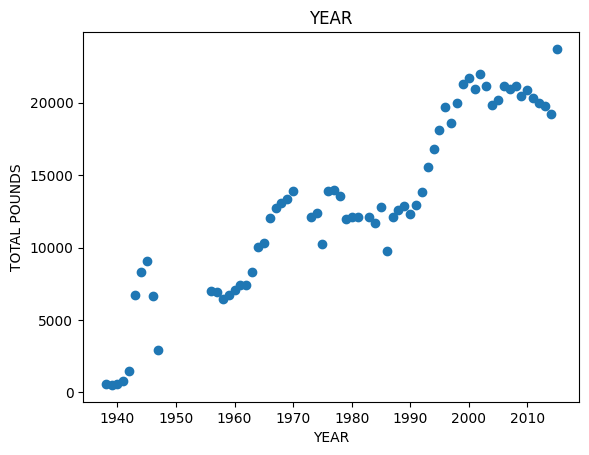

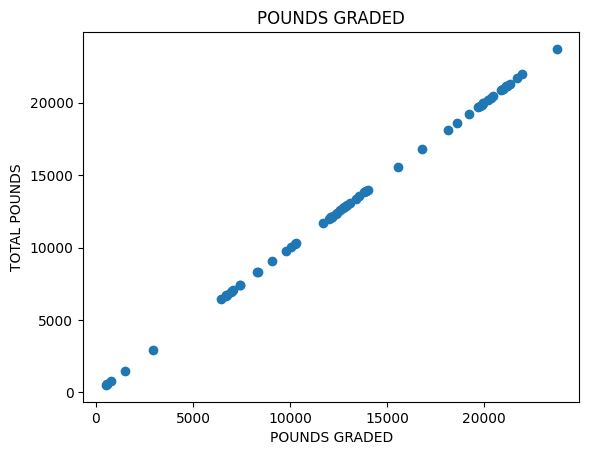

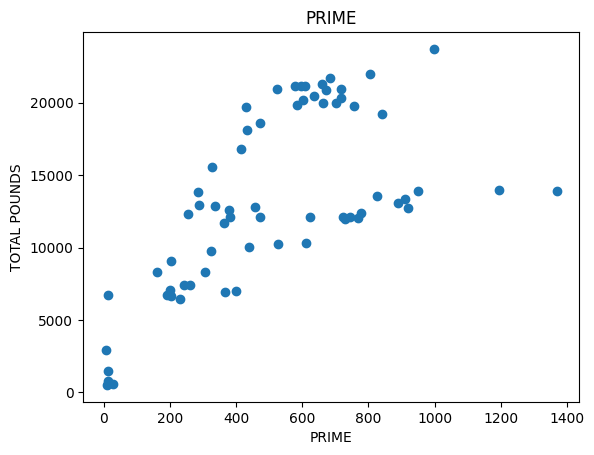

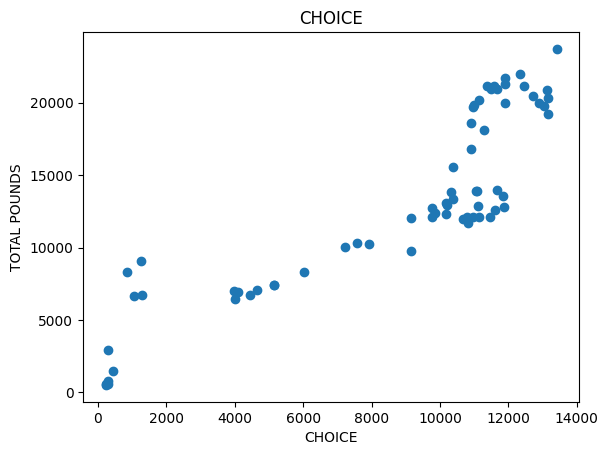

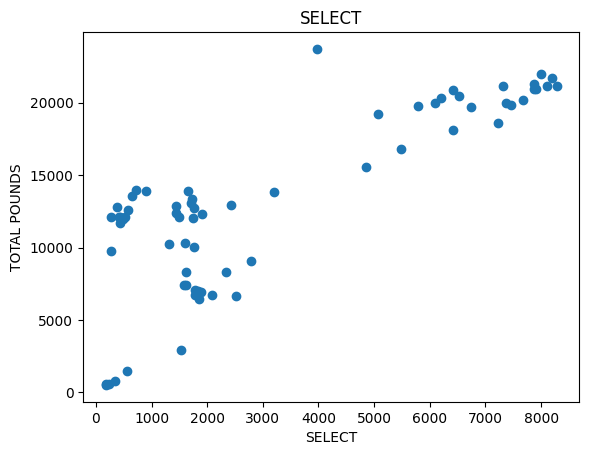

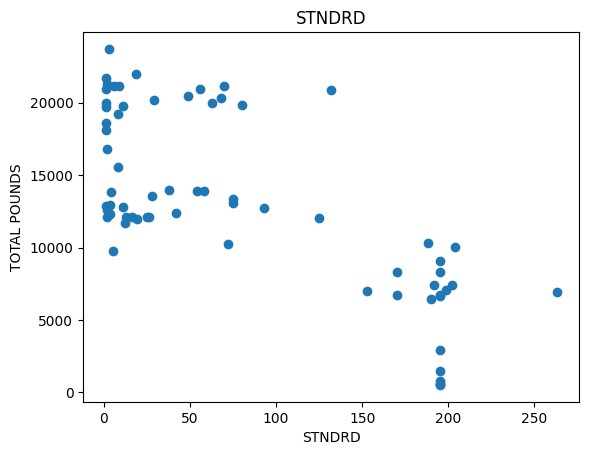

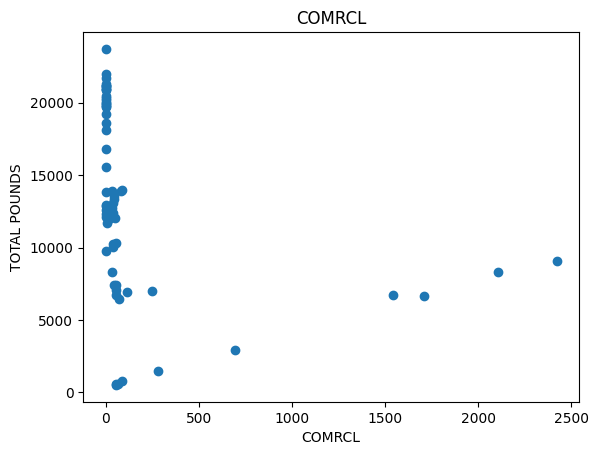

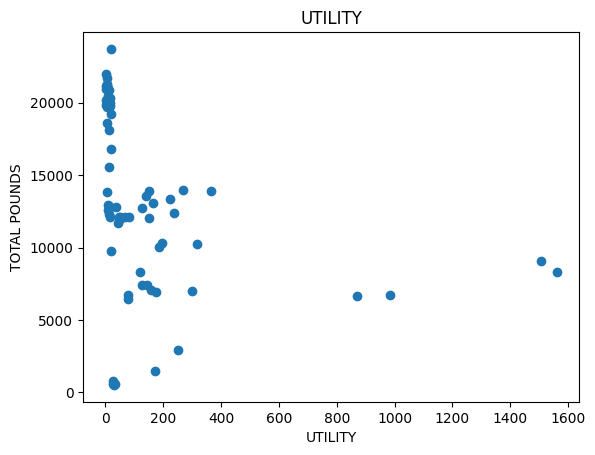

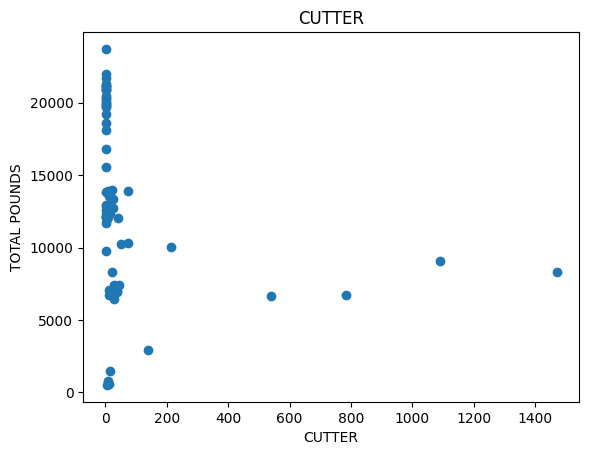

C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


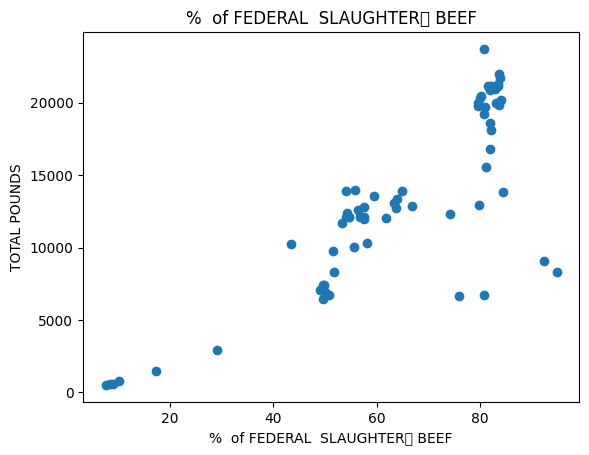

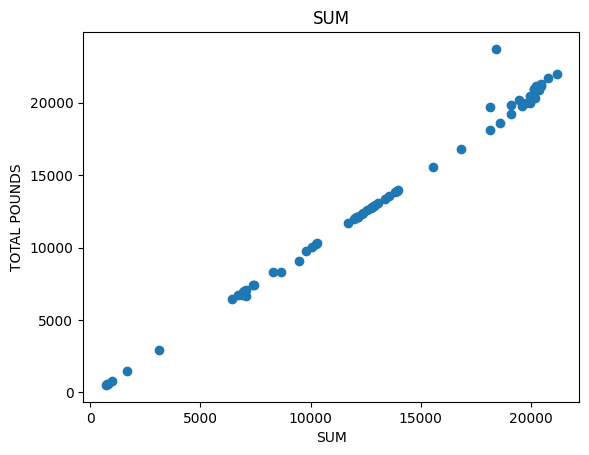

In [26]:
for i in range(len(index)):
    if i==len(index):
        break
    plt.figure()
    plt.scatter(x[:, i], y)
    plt.title(index[i])
    plt.ylabel("TOTAL POUNDS")
    plt.xlabel(index[i])
    plt.show()

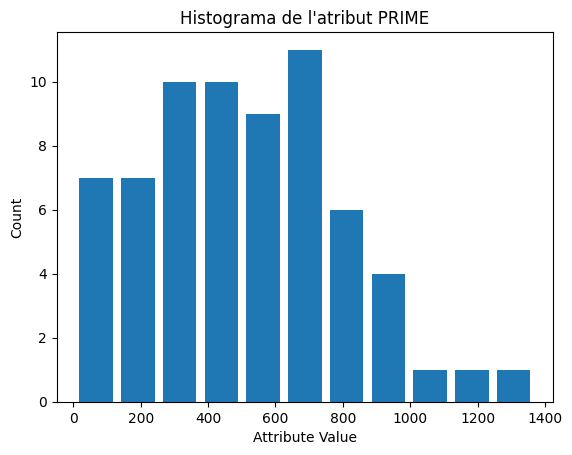

In [27]:
plt.figure()
plt.title("Histograma de l'atribut PRIME")
plt.xlabel("Attribute Value")
plt.ylabel("Count")
hist = plt.hist(x[:,2], bins=11, range=[np.min(x[:,2]), np.max(x[:,2])], histtype="bar", rwidth=0.8)

C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)


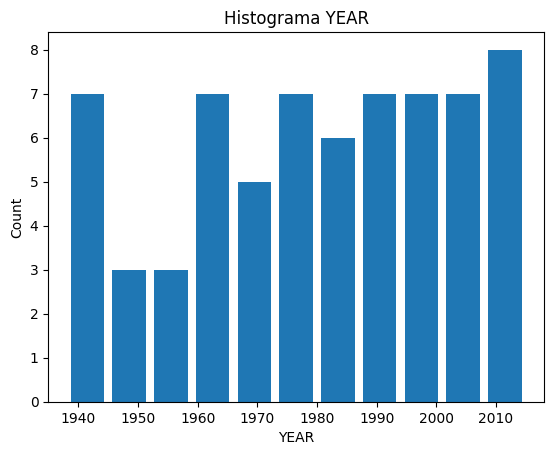

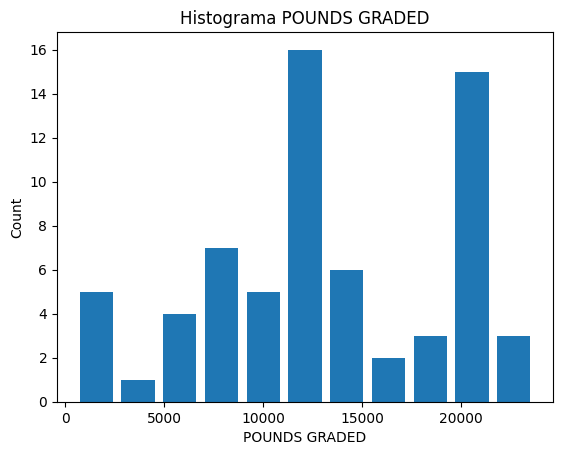

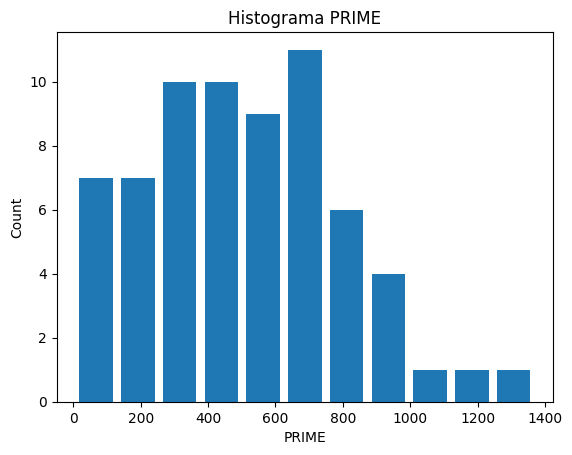

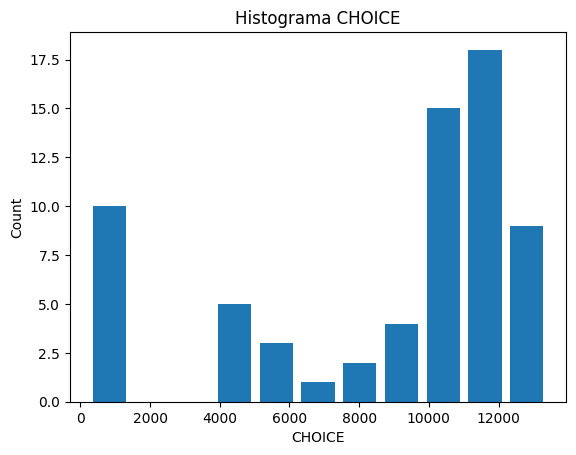

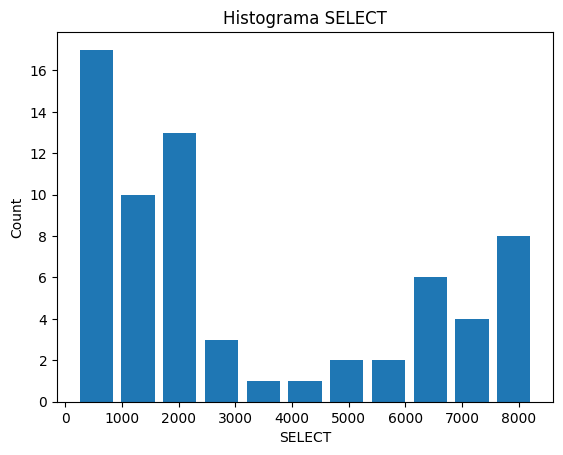

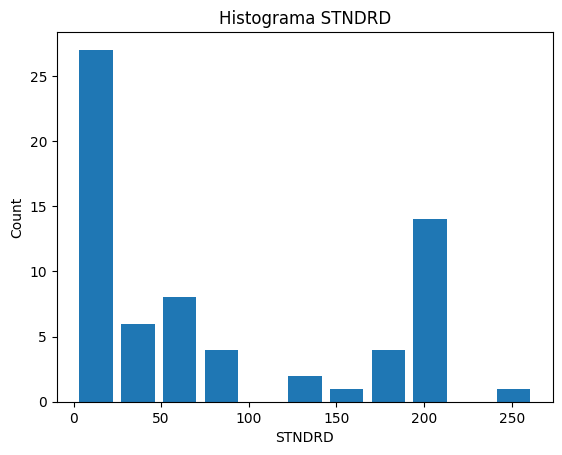

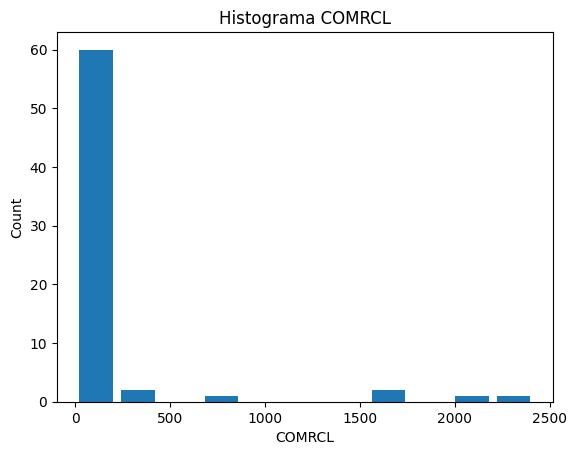

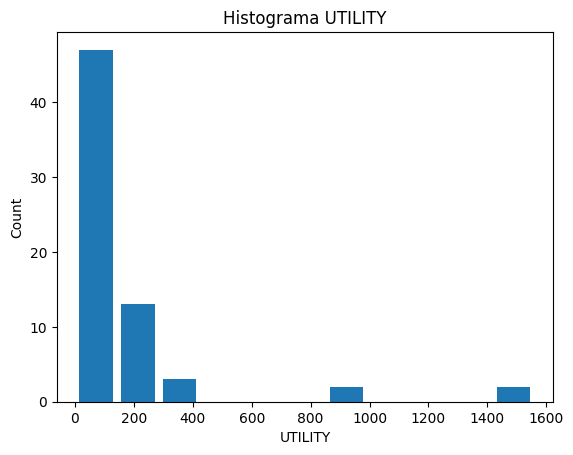

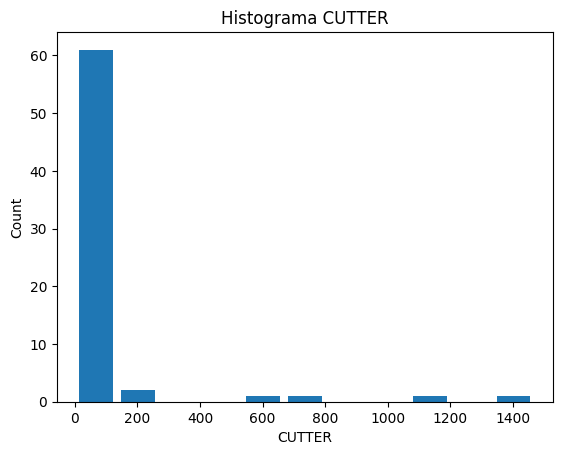

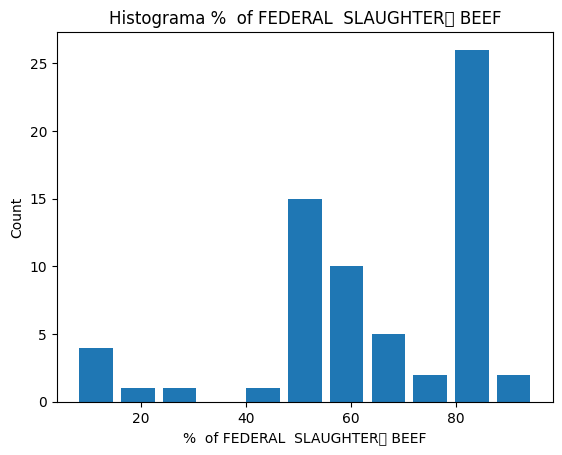

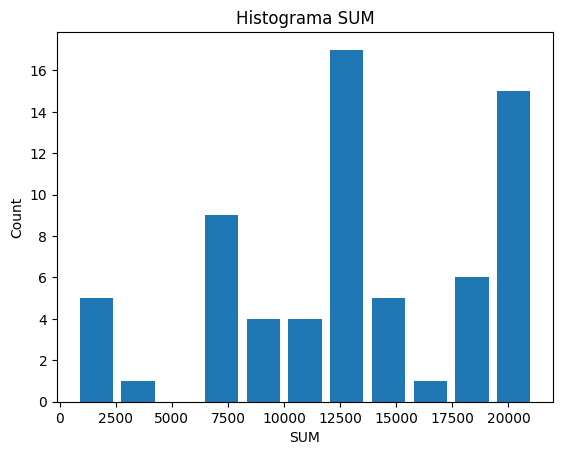

In [28]:
for i in range(len(index)):
    if i==len(index):
        print("break")
        break
    plt.figure()
    #plt.scatter(x[:, i], y)
    plt.title("Histograma " + index[i])
    plt.ylabel("Count")
    plt.xlabel(index[i])
    hist = plt.hist(x[:,i], bins=11, range=[np.min(x[:,i]), np.max(x[:,i])], histtype="bar", rwidth=0.8)

Fem el gràfic per veure les correlacions entre els atributs del dataset, incloent la nova columna de SUM

C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\matrix.py:342: UserWarning: Glyph 9 (	) missing from current font.
  ax.figure.draw(ax.figure.canvas.get_renderer())
C:\Users\adria\AppData\Local\Temp\ipykernel_12364\3682073223.py:9: UserWarning: Glyph 9 (	) missing from current font.
  ax.get_figure().savefig("images/correlacioHeatMap.png")


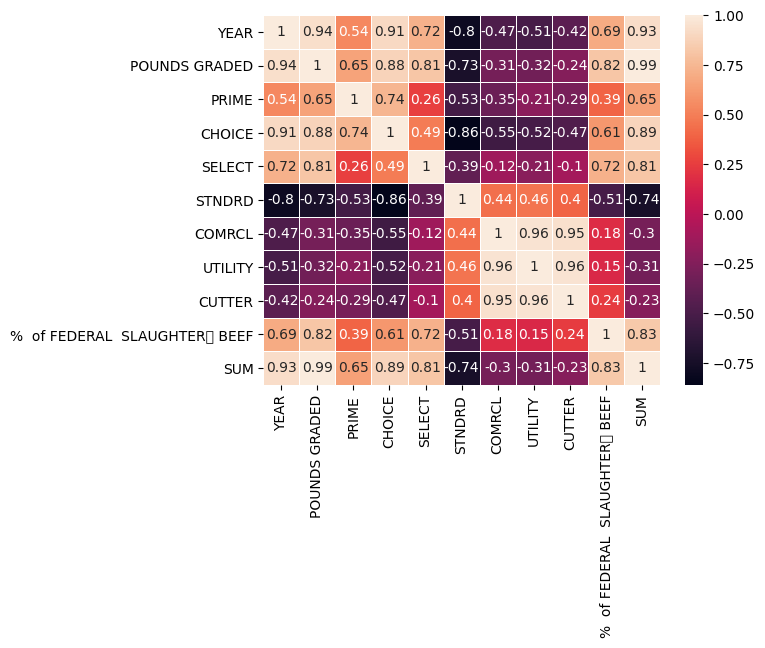

In [29]:
import seaborn as sns

# Mirem la correlació entre els atributs d'entrada per entendre millor les dades
correlacio = dfnew.corr()

plt.figure()

ax = sns.heatmap(correlacio, annot=True, linewidths=.5)
ax.get_figure().savefig("images/correlacioHeatMap.png")

També podem estudiar la correlació entre els diferents atributs per tal de saber si estan correlacionats entre ells.

C:\Users\adria\AppData\Local\Temp\ipykernel_12364\1585153528.py:9: UserWarning: Glyph 9 (	) missing from current font.
  ax.get_figure().savefig("images/correlacioFill0HeatMap.png")


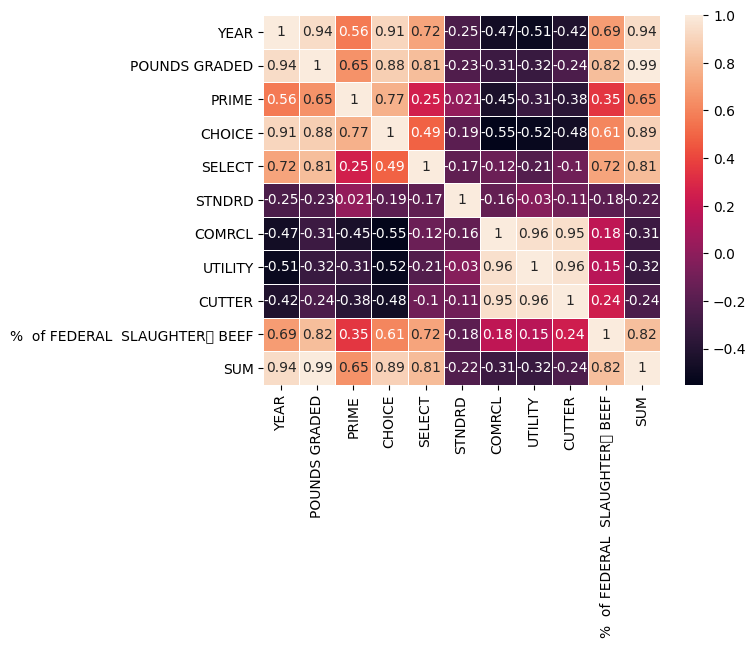

In [30]:
import seaborn as sns

# Mirem la correlació entre els atributs d'entrada per entendre millor les dades
correlacio = dfFill0.corr()

plt.figure()

ax = sns.heatmap(correlacio, annot=True, linewidths=.5)
ax.get_figure().savefig("images/correlacioFill0HeatMap.png")

C:\Users\adria\AppData\Local\Temp\ipykernel_12364\759424785.py:9: UserWarning: Glyph 9 (	) missing from current font.
  ax.get_figure().savefig("images/correlacioFillMeanHeatMap.png")


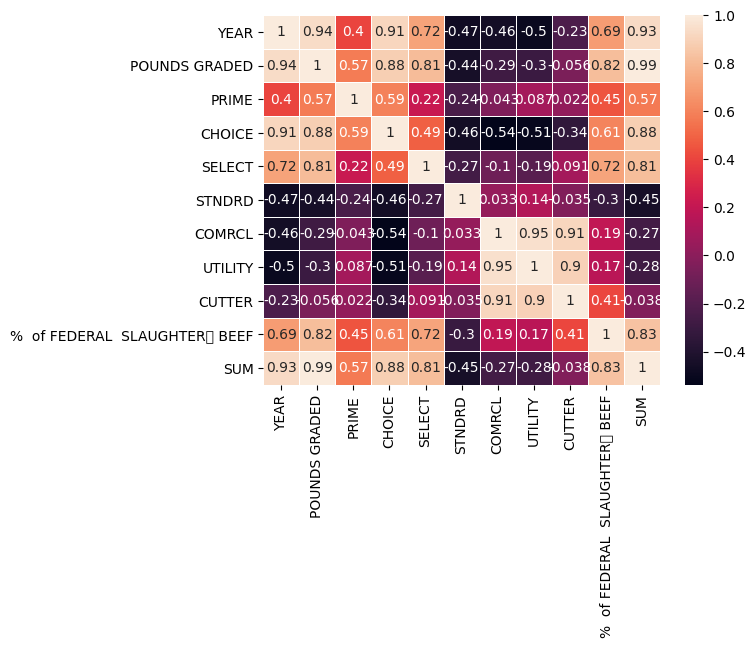

In [31]:
import seaborn as sns

# Mirem la correlació entre els atributs d'entrada per entendre millor les dades
correlacio = dfFillMean.corr()

plt.figure()

ax = sns.heatmap(correlacio, annot=True, linewidths=.5)
ax.get_figure().savefig("images/correlacioFillMeanHeatMap.png")

C:\Users\adria\AppData\Local\Temp\ipykernel_12364\1158686004.py:9: UserWarning: Glyph 9 (	) missing from current font.
  ax.get_figure().savefig("images/correlacioKnnHeatMap.png")


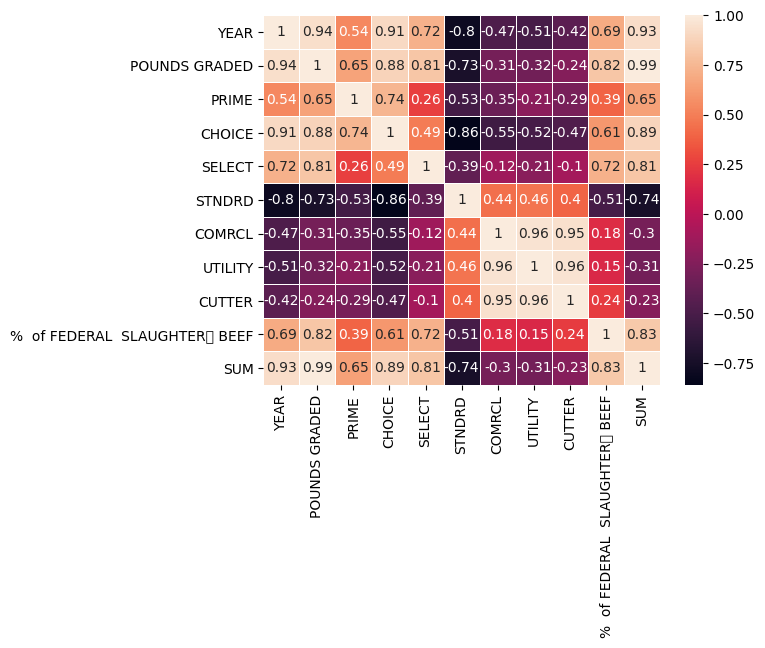

In [32]:
import seaborn as sns

# Mirem la correlació entre els atributs d'entrada per entendre millor les dades
correlacio = dfnew.corr()

plt.figure()

ax = sns.heatmap(correlacio, annot=True, linewidths=.5)
ax.get_figure().savefig("images/correlacioKnnHeatMap.png")

També podem utilitzar la funció pairplot per tal de veure els atributs que estan relacionats entre si.

C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\axisgrid.py:64: UserWarning: Glyph 9 (	) missing from current font.
  self.fig.tight_layout(*args, **kwargs)
C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\axisgrid.py:56: UserWarning: Glyph 9 (	) missing from current font.
  self.fig.savefig(*args, **kwargs)
C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, 

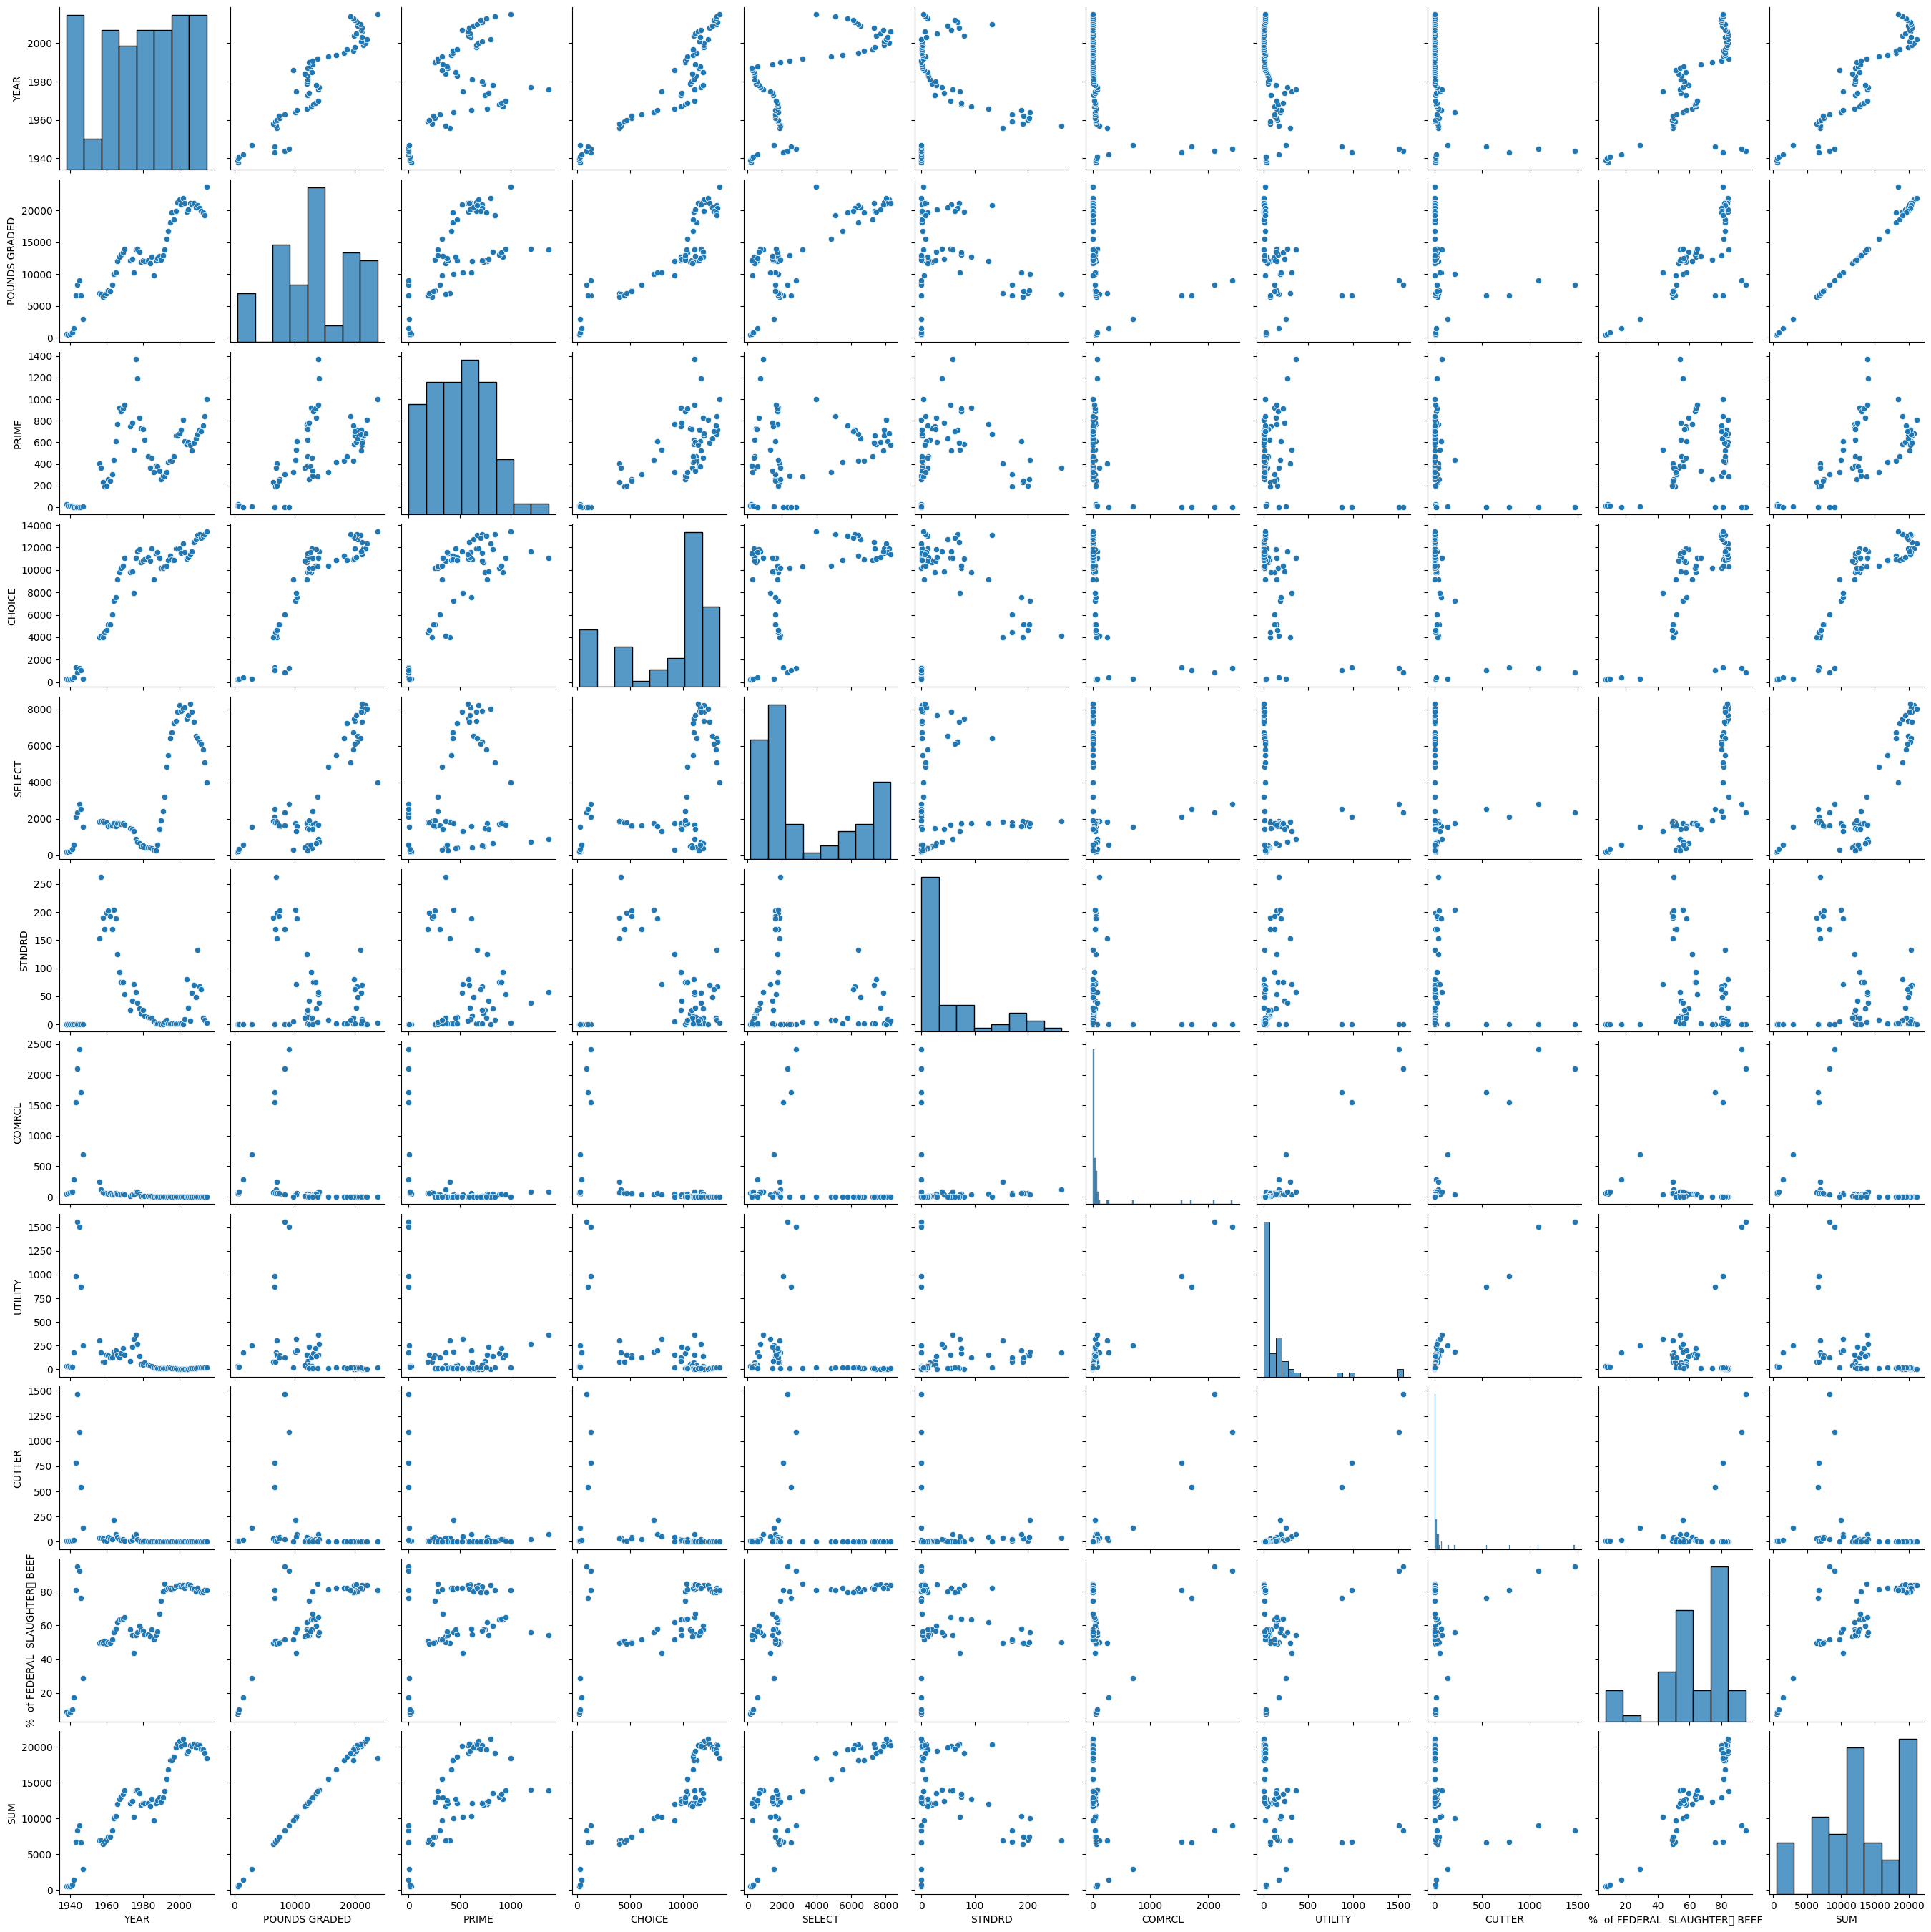

In [33]:
# Mirem la relació entre atributs utilitzant la funció pairplot
relacio = sns.pairplot(dfFill0)
relacio.savefig("images/dfFill0Pairplot")

C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\axisgrid.py:64: UserWarning: Glyph 9 (	) missing from current font.
  self.fig.tight_layout(*args, **kwargs)
C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\axisgrid.py:56: UserWarning: Glyph 9 (	) missing from current font.
  self.fig.savefig(*args, **kwargs)
C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, 

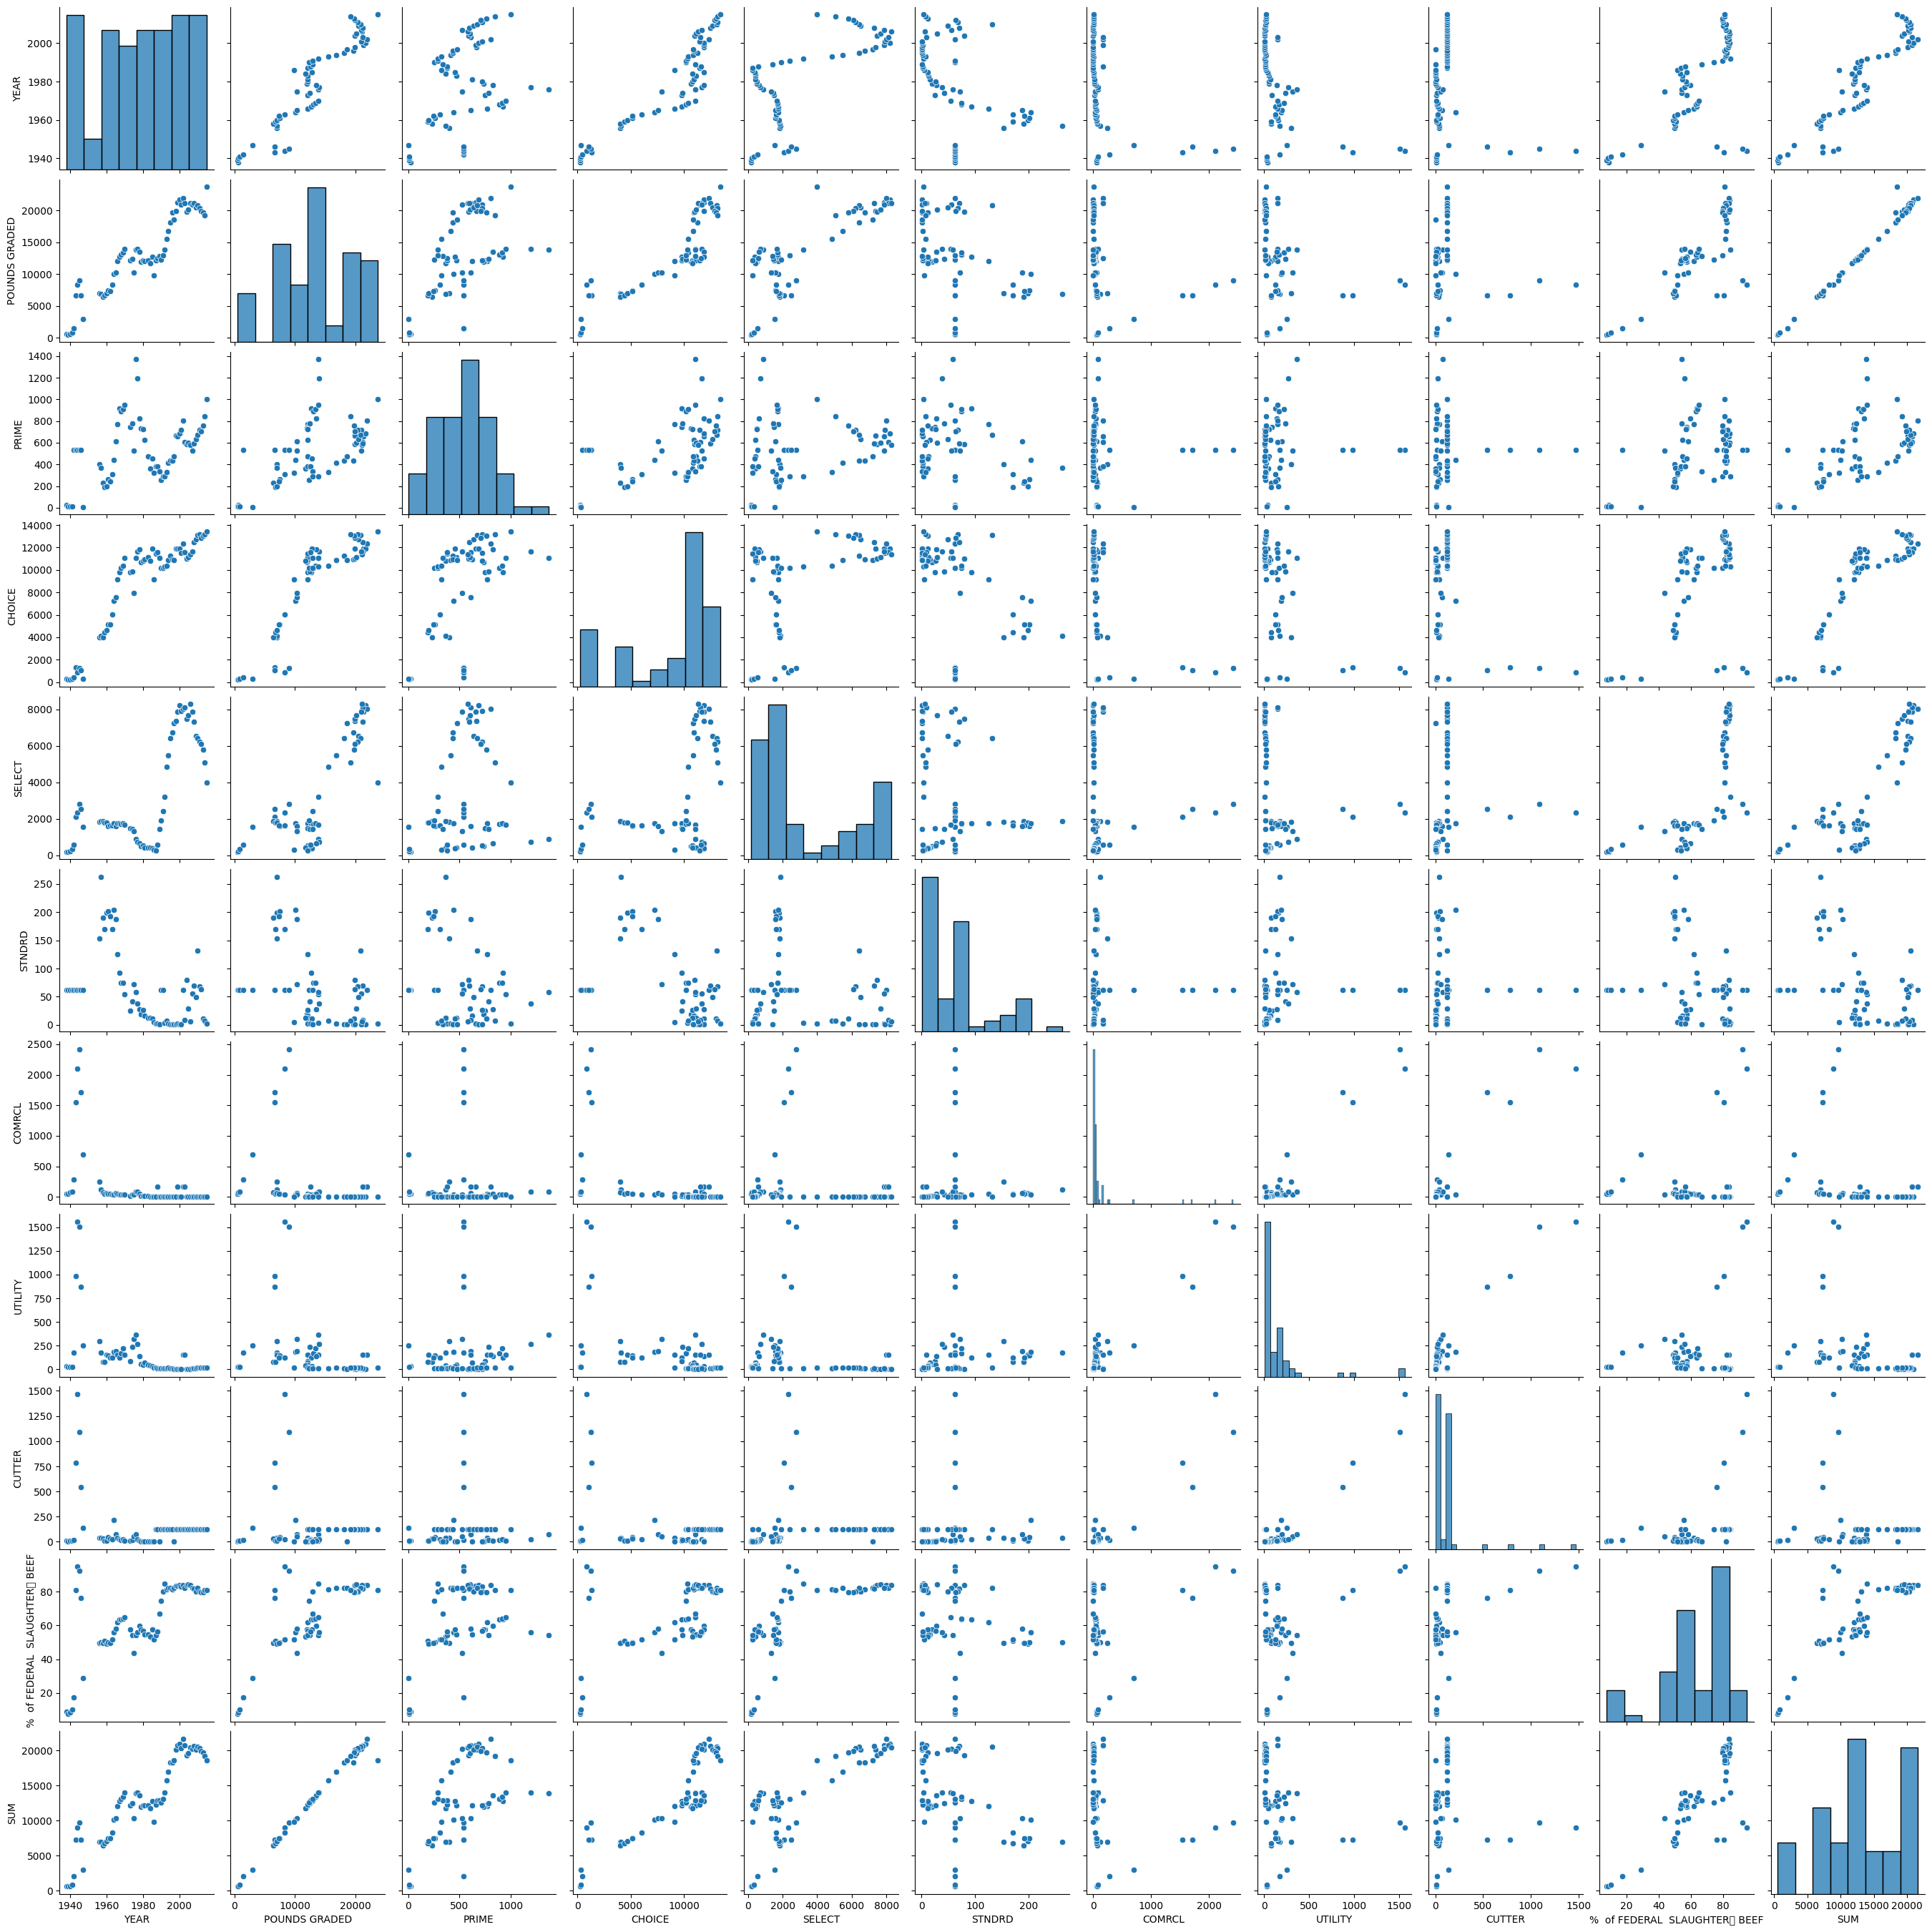

In [34]:
# Mirem la relació entre atributs utilitzant la funció pairplot
relacio = sns.pairplot(dfFillMean)
relacio.savefig("images/dfFillMeanPairplot")

C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\axisgrid.py:64: UserWarning: Glyph 9 (	) missing from current font.
  self.fig.tight_layout(*args, **kwargs)
C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\seaborn\axisgrid.py:56: UserWarning: Glyph 9 (	) missing from current font.
  self.fig.savefig(*args, **kwargs)
C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
C:\Users\adria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, 

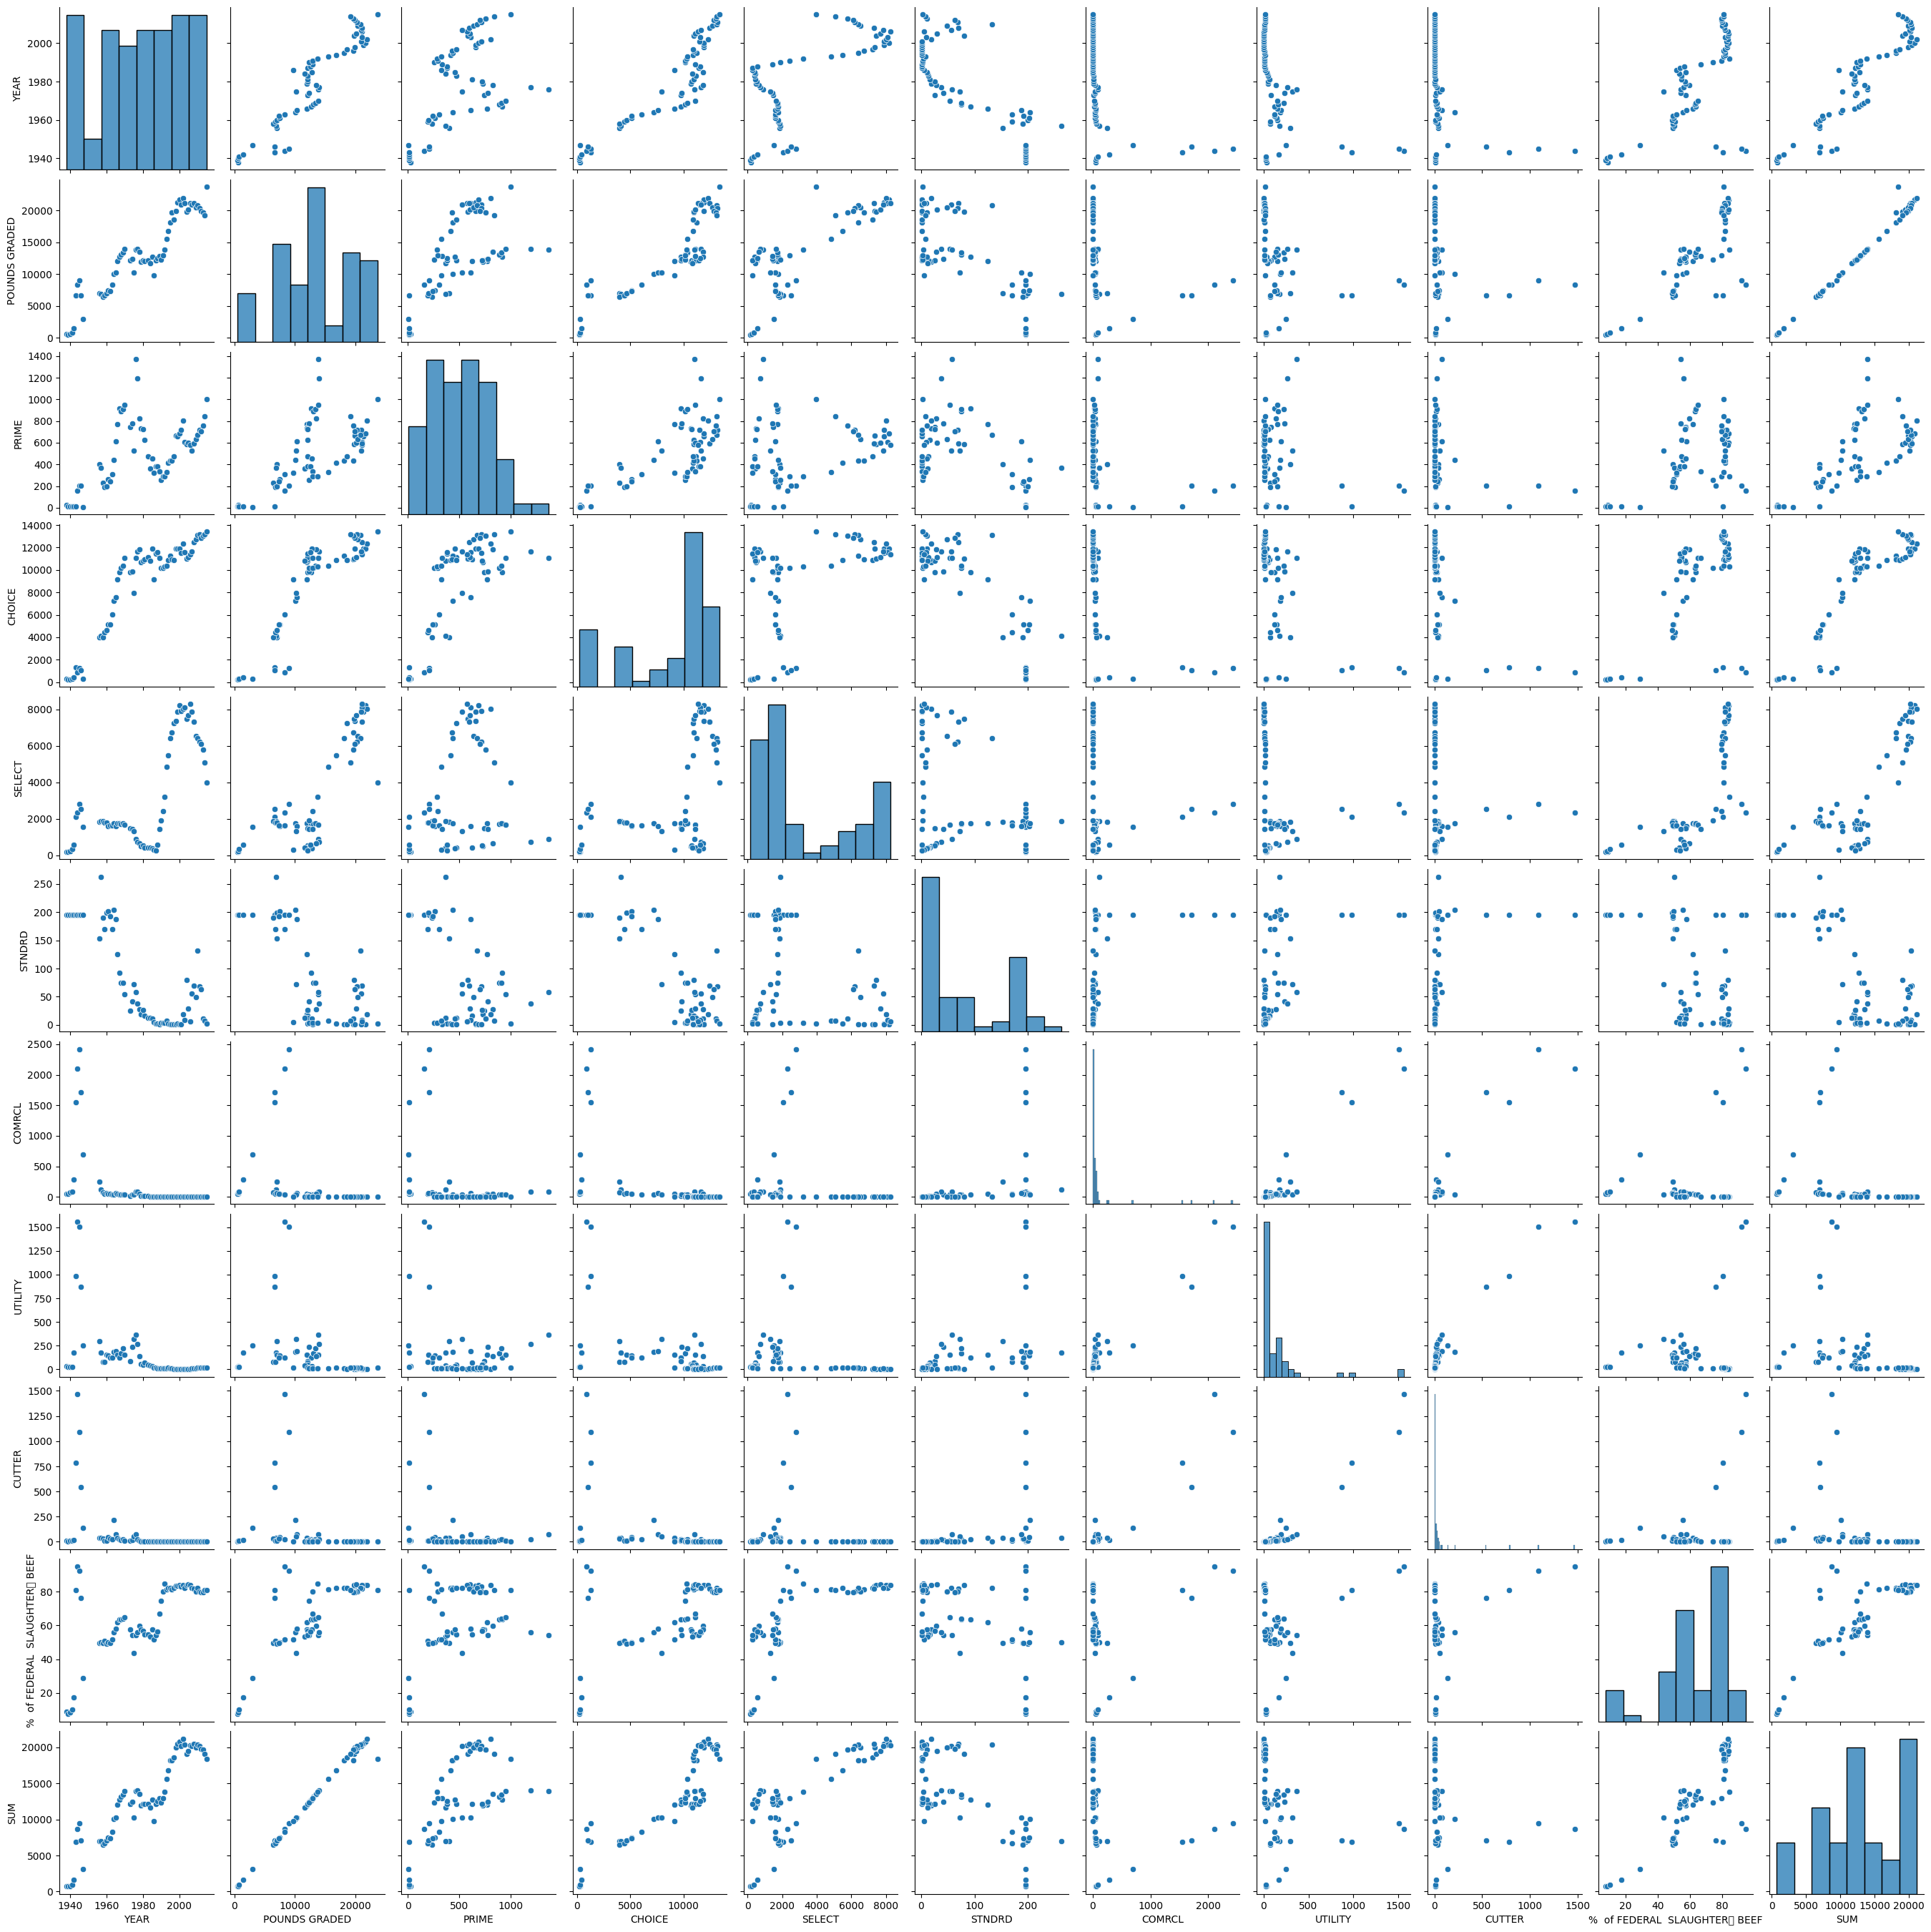

In [35]:
# Mirem la relació entre atributs utilitzant la funció pairplot
relacio = sns.pairplot(dfnew)
relacio.savefig("images/dfnewPairplot")

In [36]:
dfnew.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67 entries, 0 to 66
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   YEAR                            67 non-null     float64
 1   POUNDS GRADED                   67 non-null     float64
 2   PRIME                           67 non-null     float64
 3   CHOICE                          67 non-null     float64
 4   SELECT                          67 non-null     float64
 5   STNDRD                          67 non-null     float64
 6   COMRCL                          67 non-null     float64
 7   UTILITY                         67 non-null     float64
 8   CUTTER                          67 non-null     float64
 9   %  of FEDERAL  SLAUGHTER	 BEEF  67 non-null     float64
 10  SUM                             67 non-null     float64
dtypes: float64(11)
memory usage: 5.9 KB


In [37]:
print(dfnew.shape)
dataNew = dfnew.values
x = dataNew[:83, 0:11]
y = dataNew[:83, 1]

dataFill0 = dfFill0.values
xFill0 = dataFill0[:83, 0:11]
yFill0 = dataFill0[:83, 1]

dataFillMean = dfFillMean.values
xFillMean = dataFillMean[:83, 0:11]
yFillMean = dataFillMean[:83, 1]

(67, 11)


Així doncs ara podreu respondre a les següents preguntes:

1. Quin és el tipus de cada atribut? adjuntar foto dfnew.info()
2. Quins atributs tenen una distribució Guassiana? El prime
3. Quin és l'atribut objectiu? Per què? POUNDS GRADED (mayor correlació amb els anys)

# Apartat (B): Primeres regressions

Per a aquest primer apartat es calcularà l'error quadràtic mitjà només del regressor per a cada un dels atributs de la base de dades, determinant aquell atribut pel qual l'error quadràtic mitjà (entre el valor predit i el real, per a cada mostra) és més baix. 

A continuació se us dona una funció auxiliar per a calcular l'error quadràtic mitjà:

In [38]:
import math

def mean_squeared_error(y1, y2):
    # comprovem que y1 i y2 tenen la mateixa mida
    assert(len(y1) == len(y2))
    mse = 0
    for i in range(len(y1)):
        mse += (y1[i] - y2[i])**2
    return mse / len(y1)

mean_squeared_error([1,2,3,4], [1,2,1,4])

1.0

Per a agilitzar els càlculs es recomana utilitzar la llibreria numpy. Aquesta llibreria ens permet processar vectors sencers a la vegada de manera eficient i en paral·lel. Exemple:

In [39]:
import numpy as np #importem la llibreria
np.warnings.filterwarnings('ignore')

vector1 = np.array([1,2,3,4]) # convertim llista de python a numpy array
vector2 = np.array([1,2,1,4]) 

# podem sumar dos vectors element a element
print("Suma vector1 + vector2 ", vector1 + vector2)

# podem sumar tots els valors d'un vector
print("Suma valors vector1 ", vector1.sum())

# calculem la mitjana
print("Mitjana vector1", vector1.mean())

# utilitzem un vector com a índex de l'altre
# vector3 = vector1  # necesitem fer una copia del vector per no modificar el original
vector3 = vector1.copy()
vector3[vector2 == 1] = 5
print("Vector1 amb un 5 on el Vector2 te 1s ", vector3)

# es pot utilitzar numpy per a calcular el mse
def mse(v1, v2):
    return ((v1 - v2)**2).mean()

print("MSE: ", mse(vector1, vector2))

Suma vector1 + vector2  [2 4 4 8]
Suma valors vector1  10
Mitjana vector1 2.5
Vector1 amb un 5 on el Vector2 te 1s  [5 2 5 4]
MSE:  1.0


Per a la regressió podeu utilitzar la llibreria sklearn:

In [40]:
from sklearn.linear_model import LinearRegression

def regression(x, y):
    # Creem un objecte de regressió de sklearn
    regr = LinearRegression()

    # Entrenem el model per a predir y a partir de x
    regr.fit(x, y)

    # Retornem el model entrenat
    return regr

Finalment, si la funció `fit` del regressor logístic dónes l'error: `ValueError: Unknown label type: 'unknown'`, caldria afegir a la definició de l'atribut a trobar $y$ la crida a la funció `.astype('int')` per tal de obligar a que les dades siguin de tipus sencer, deixant el codi com segueix:

`y = data[:,2].astype('int')`

A continuació, es modificaran tots els atributs mitjançant **procediments de normalització (normal, estàndard)**, i s'avaluarà el rendiment del regressor après. Per a això, caldrà analitzar la mitja i variança de cada variable per totes les mostres, per identificar aquells valors que tenen una distribució normal, els preferits per fer regressió, i descartar altres atributs que no són representatius per fer la regressió, i que afegeixen soroll al model. 

Pel que fa a l'error resultant de la regressió, recordeu que es calcula fent la diferència entre el valor predit i el real al quadrat: així doncs, si les dades tenen valors grans (tipus 10^3), l'error al quadrat podria acabar sent 10^6. Per això és important normalitzar abans (escalar les dades a un rang més petit).

<img src="images/standarization.png">

Podeu estandarditzar les dades amb les funcions mean i std de numpy i mostrar l'hisotgrama de nou. Recuperant l'exemple de l'apartat anterior:

In [41]:
def standarize(x_train):
    mean = x_train.mean(0)
    std = x_train.std(0)
    x_t = x_train - mean[None, :]
    x_t /= std[None, :]
    return x_t

x_t = standarize(x)

Ara ja podeu comprovar la diferència entre entrenar amb els atributs estandaritzats i si aquells que tenen una distribució més semblant a la normal donen millors resultats. 
Finalment, s'aprendrà un model regressor tenint en compte tots aquells atributs que tenen una millor distribució de valors (lineal, això és, l'histograma de valors té forma de gaussiana), i es calcularà l'error assolit en la predicció. 

Recordeu que el valor sobre el que heu de fer la regressió queda al vostre criteri: **heu d'explicar a la memòria quin atribut heu fet servir, no hi ha una decisió única correcta, cal que doneu raons de per què heu triat l'atribut que hàgiu triat.**

Així per exemple pode mirar:

* Que l'objectiu de la regressió sigui un valor ordinal (1 > 2 > 3). Si no n'hi ha cap, explicar-ho a la memòria.

* Que sigui útil en alguna aplicació real (per exemple predir si plourà és més interessant que predir el color dels núvols).

* Que tingui certa variació (un atribut que és sempre 0, no té gaire interès)

I en definitiva explicar el criteri a seguir, tant amb paraules com amb gràfiques (per exemple histograma), o estadístiques (per exemple la variança dels atributs) si escau.

Un cop escollit l'atribut objectiu, caldrà justificar si l'error obtingut és, en proporció, menor que tenint en compte únicament el millor atribut identificat al primer punt. 

Podeu utilitzar les funcions hist de matplotlib per a calcular els histogrames.

o utilitzar les funcions de visualitzación del propi pandas.

Ara que hem carregat les dades podem entrenar un regressor lineal per a aproximar la funció que les genera:

Regressió sense normalitzar

(67, 11)
Mean squeared error  YEAR :  4605950.294898352
R2 score:  0.8778191593718118
Mean squeared error  POUNDS GRADED :  1.1279788236430314e-23
R2 score:  1.0
Mean squeared error  PRIME :  21701983.512281522
R2 score:  0.4243171508458159
Mean squeared error  CHOICE :  8514741.790275076
R2 score:  0.7741316681554131
Mean squeared error  SELECT :  12769245.163558425
R2 score:  0.6612735682364921
Mean squeared error  STNDRD :  35771280.65717755
R2 score:  0.05110457968212667
Mean squeared error  COMRCL :  34175556.75569288
R2 score:  0.09343393089328511
Mean squeared error  UTILITY :  33798309.5722154
R2 score:  0.1034410684112359
Mean squeared error  CUTTER :  35478391.24225527
R2 score:  0.05887398070365746
Mean squeared error  %  of FEDERAL  SLAUGHTER	 BEEF :  12570033.243707655
R2 score:  0.6665580108101521
Mean squeared error  SUM :  427224.7768383689
R2 score:  0.9886671199146203


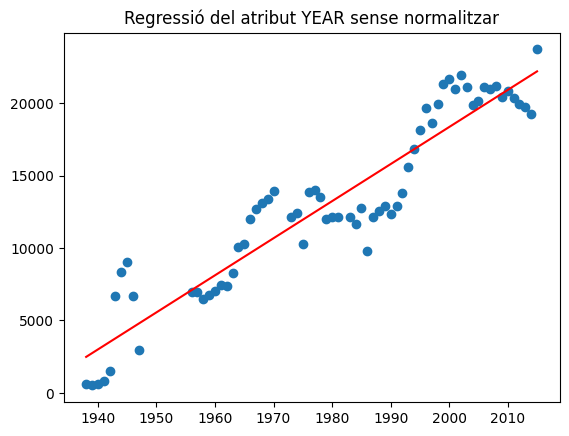

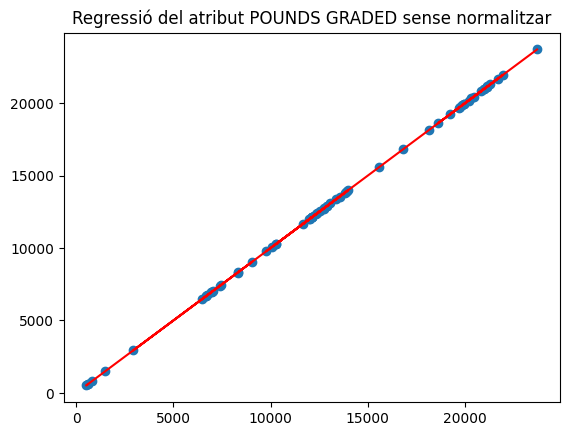

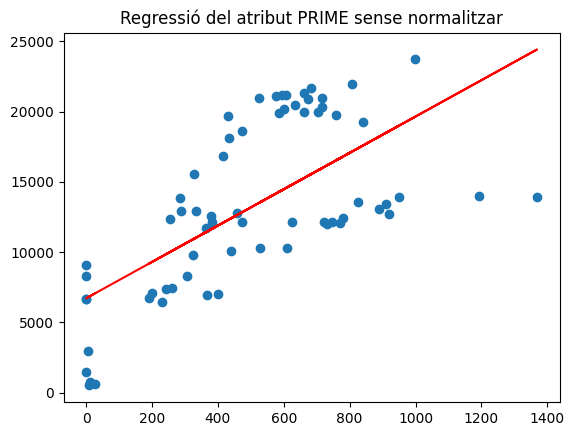

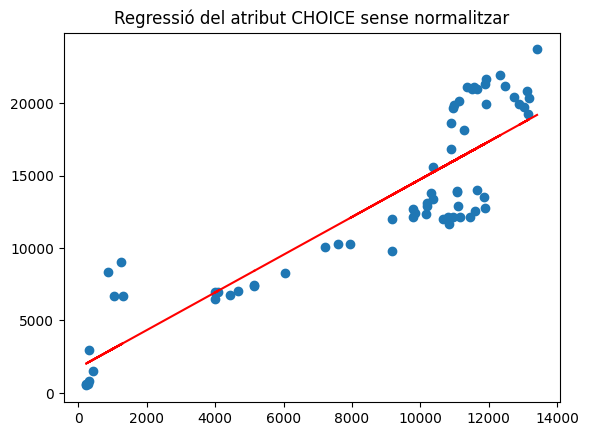

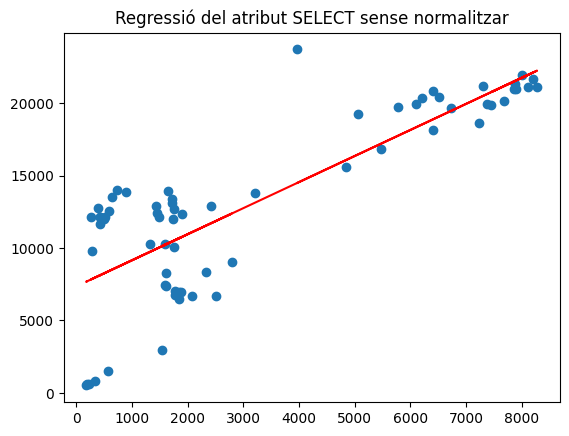

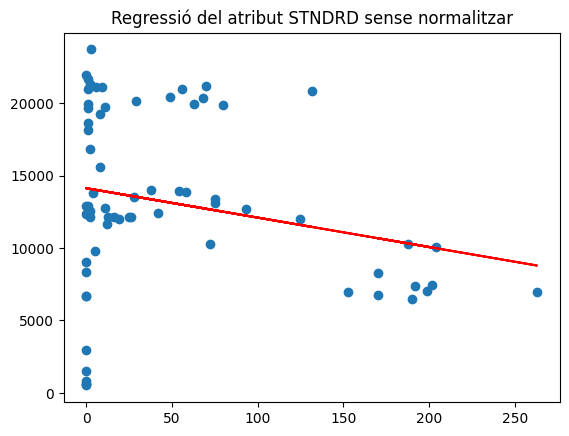

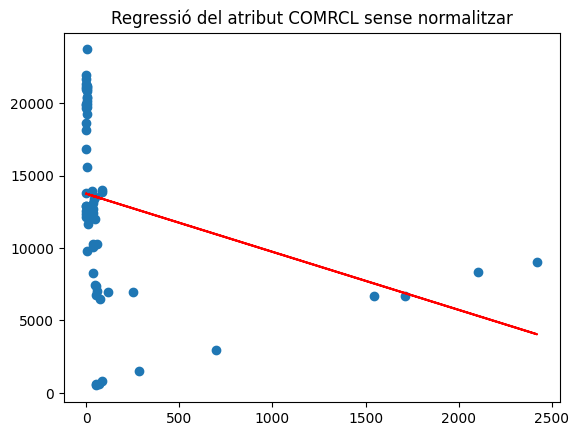

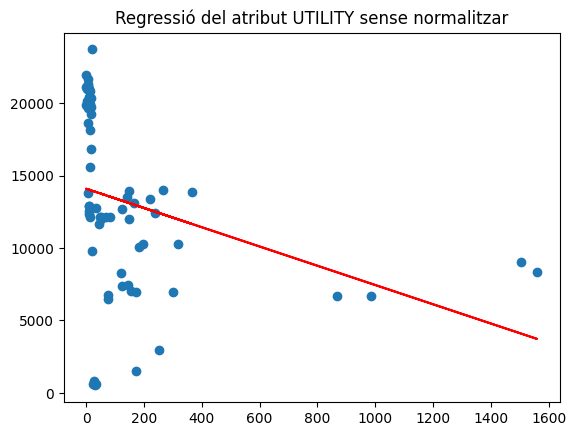

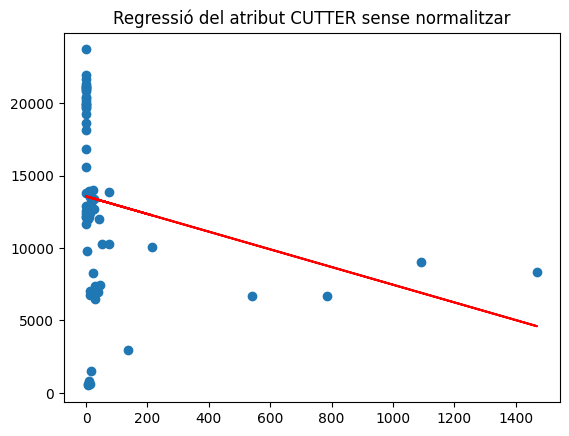

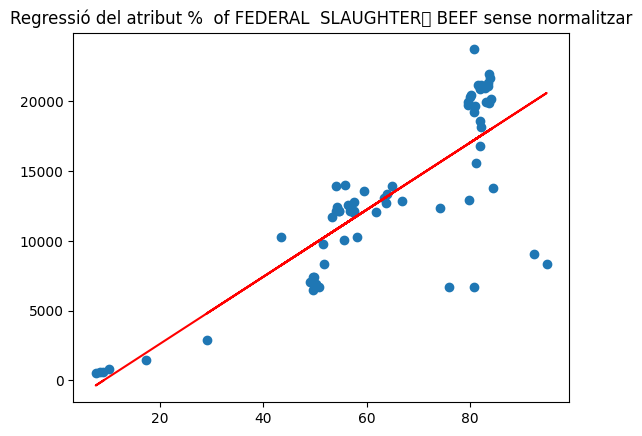

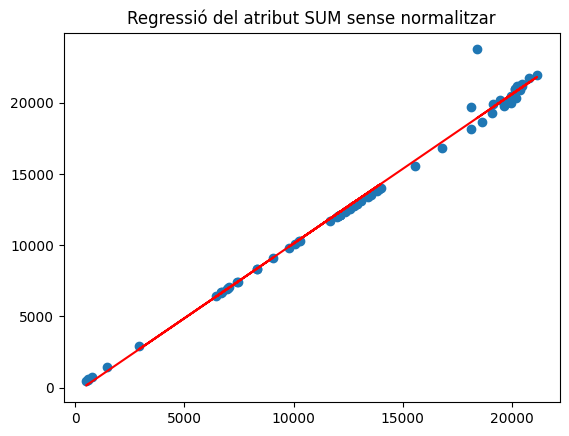

In [42]:
##dataset fill 0
from sklearn.metrics import r2_score

index = dfFill0.columns[:13]
print(xFill0.shape)
# Extraiem el primer atribut de x i canviem la mida a #exemples, #dimensions de l'atribut.
# En el vostre cas, haureu de triar un atribut com a y, i utilitzar la resta com a x.
for index1 in range(xFill0.shape[1]):
    atribut1 = xFill0[:,index1].reshape(xFill0.shape[0], 1) 
    regr = regression(atribut1, yFill0) 
    predicted = regr.predict(atribut1)

    # Mostrem la predicció del model entrenat en color vermell a la Figura anterior 1
    plt.figure()
    plt.title("Regressió del atribut {} sense normalitzar".format(index[index1]))
    ax = plt.scatter(xFill0[:,index1], yFill0)
    plt.plot(atribut1[:,0], predicted, 'r')

    # Mostrem l'error (MSE i R2)
    MSE = mse(yFill0, predicted)
    r2 = r2_score(yFill0, predicted)

    print("Mean squeared error ",index[index1],": ", MSE)
    print("R2 score: ", r2)

Mean squeared error  YEAR :  4605950.294898352
R2 score:  0.8778191593718118
Mean squeared error  POUNDS GRADED :  1.1279788236430314e-23
R2 score:  1.0
Mean squeared error  PRIME :  25291940.622358542
R2 score:  0.32908729610461707
Mean squeared error  CHOICE :  8514741.790275076
R2 score:  0.7741316681554131
Mean squeared error  SELECT :  12769245.163558425
R2 score:  0.6612735682364921
Mean squeared error  STNDRD :  30286231.44144734
R2 score:  0.19660504780641253
Mean squeared error  COMRCL :  34623164.47696191
R2 score:  0.08156035776400195
Mean squeared error  UTILITY :  34261839.86500585
R2 score:  0.09114512138538611
Mean squeared error  CUTTER :  37580202.93352281
R2 score:  0.003119770857827997
Mean squeared error  %  of FEDERAL  SLAUGHTER	 BEEF :  12570033.243707655
R2 score:  0.6665580108101521
Mean squeared error  SUM :  434495.04860945116
R2 score:  0.9884742633139814


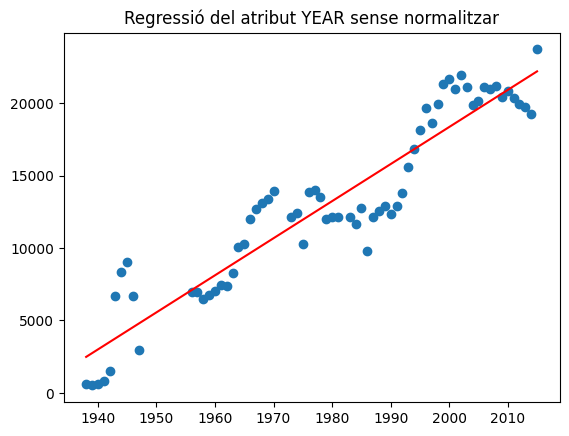

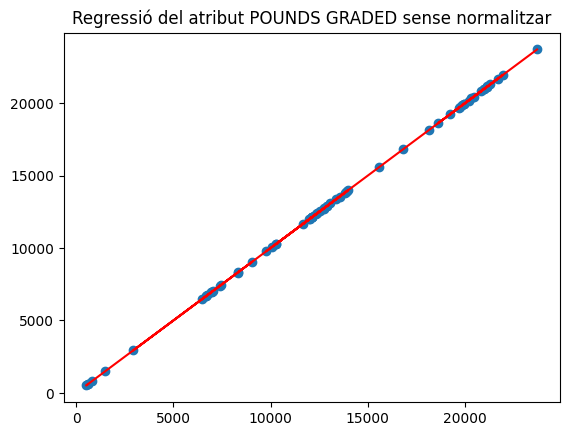

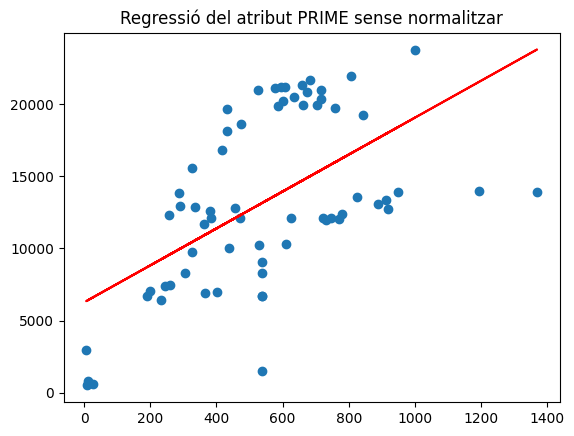

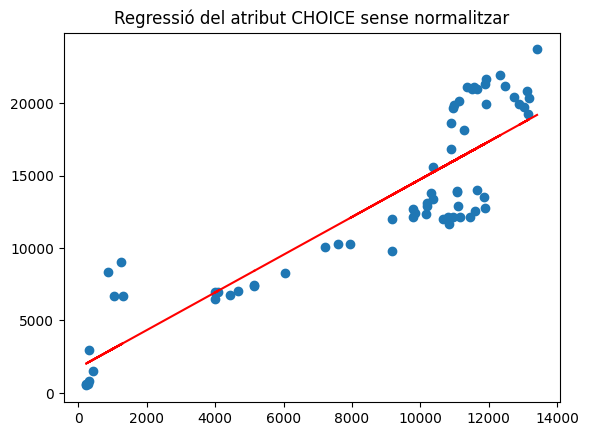

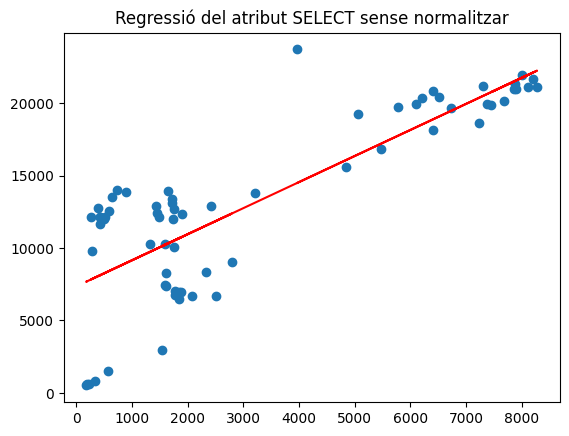

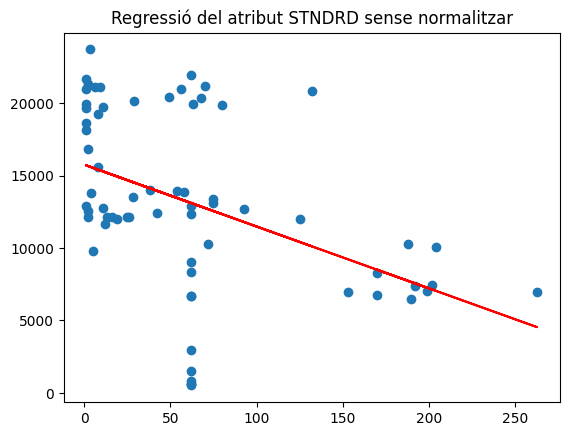

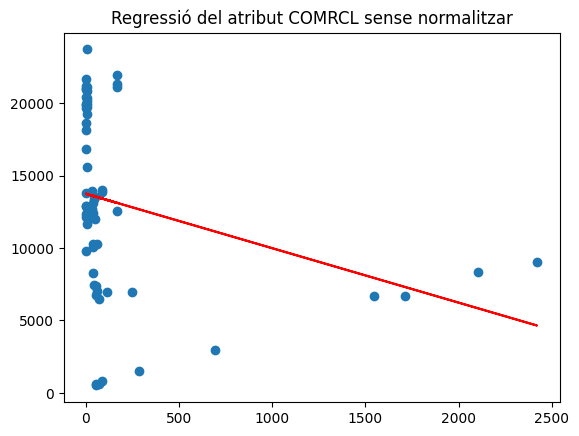

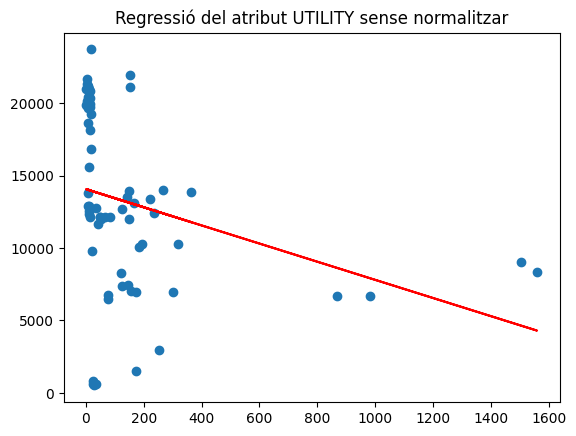

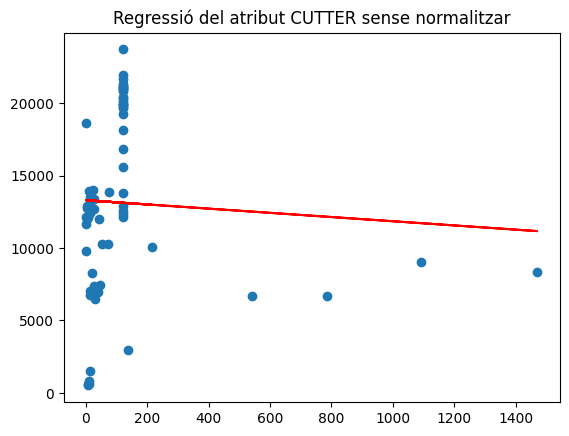

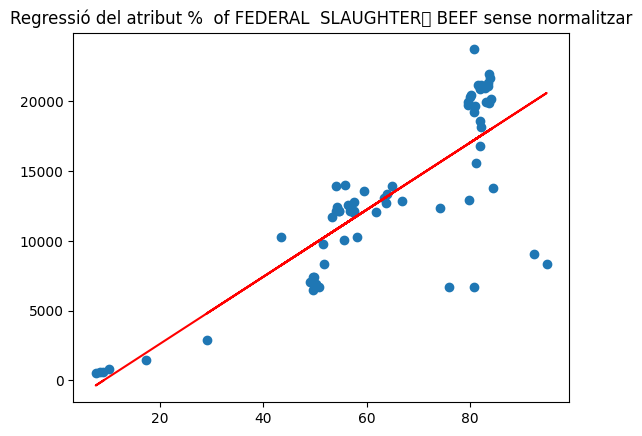

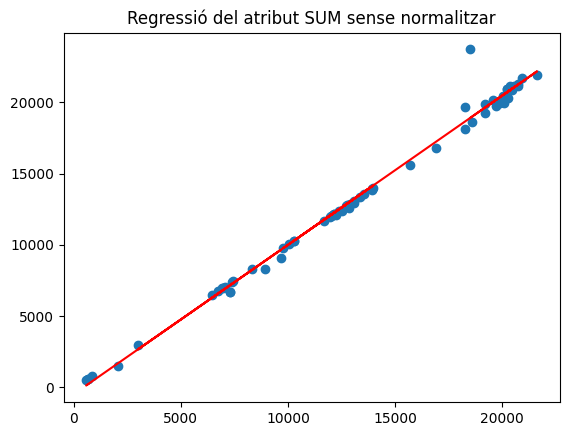

In [43]:
from sklearn.metrics import r2_score

# Extraiem el primer atribut de x i canviem la mida a #exemples, #dimensions de l'atribut.
# En el vostre cas, haureu de triar un atribut com a y, i utilitzar la resta com a x.
for index1 in range(xFillMean.shape[1]):
    atribut1 = xFillMean[:,index1].reshape(xFillMean.shape[0], 1) 
    regr = regression(atribut1, yFillMean) 
    predicted = regr.predict(atribut1)

    # Mostrem la predicció del model entrenat en color vermell a la Figura anterior 1
    plt.figure()
    plt.title("Regressió del atribut {} sense normalitzar".format(index[index1]))
    ax = plt.scatter(xFillMean[:,index1], yFillMean)
    plt.plot(atribut1[:,0], predicted, 'r')

    # Mostrem l'error (MSE i R2)
    MSE = mse(yFillMean, predicted)
    r2 = r2_score(yFillMean, predicted)

    print("Mean squeared error ",index[index1],": ", MSE)
    print("R2 score: ", r2)

Mean squeared error  YEAR :  4605950.294898352
R2 score:  0.8778191593718118
Mean squeared error  POUNDS GRADED :  1.1279788236430314e-23
R2 score:  1.0
Mean squeared error  PRIME :  21680954.93606355
R2 score:  0.42487497039553435
Mean squeared error  CHOICE :  8514741.790275076
R2 score:  0.7741316681554131
Mean squeared error  SELECT :  12769245.163558425
R2 score:  0.6612735682364921
Mean squeared error  STNDRD :  17366822.727031607
R2 score:  0.5393148288682793
Mean squeared error  COMRCL :  34179458.59450738
R2 score:  0.09333042783401835
Mean squeared error  UTILITY :  33808072.50590075
R2 score:  0.10318208961895625
Mean squeared error  CUTTER :  35535119.881887674
R2 score:  0.05736915489482097
Mean squeared error  %  of FEDERAL  SLAUGHTER	 BEEF :  12570033.243707655
R2 score:  0.6665580108101521
Mean squeared error  SUM :  422696.9676677511
R2 score:  0.9887872279260513


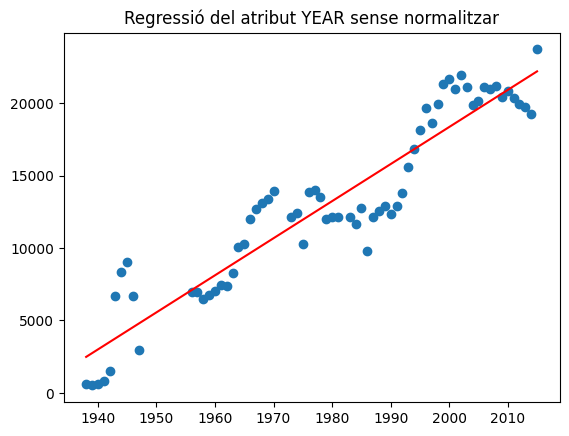

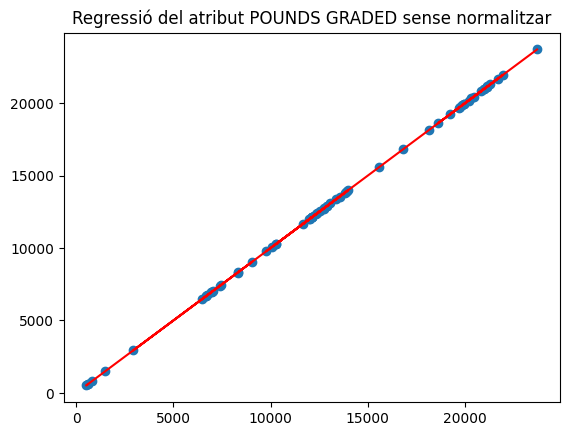

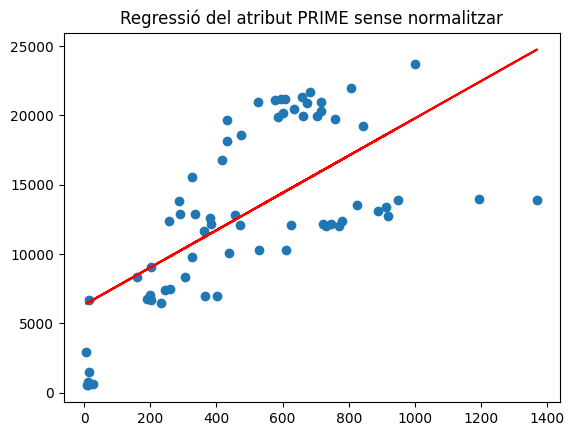

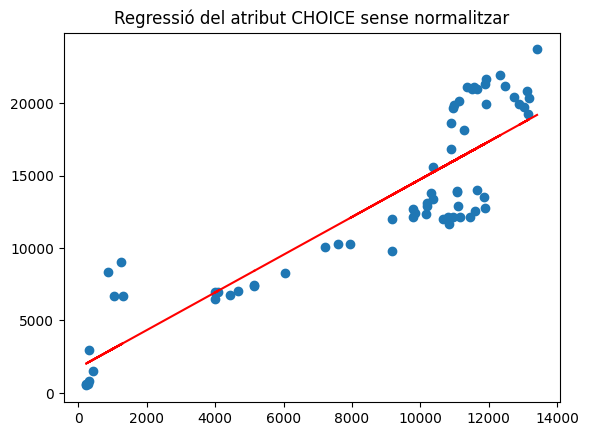

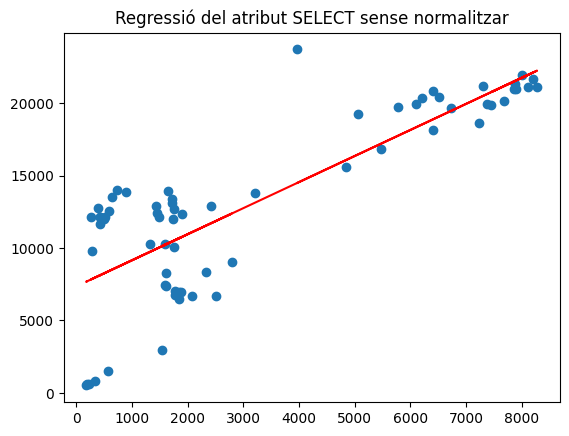

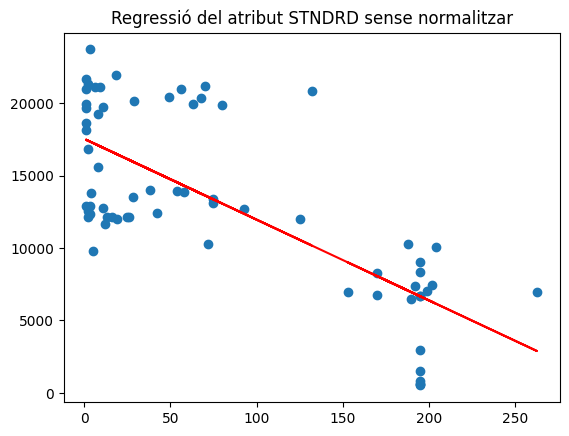

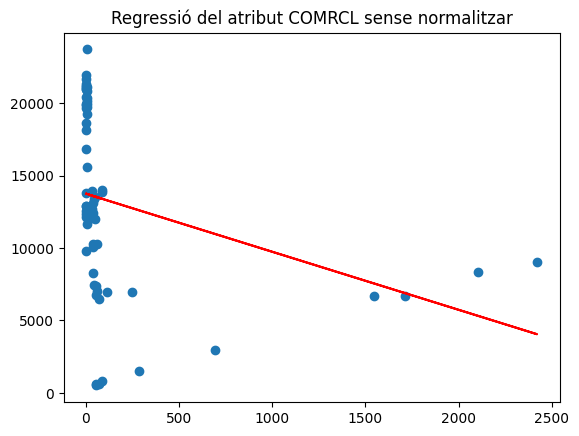

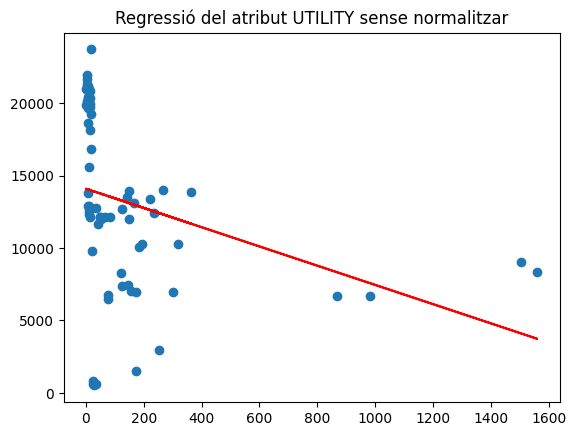

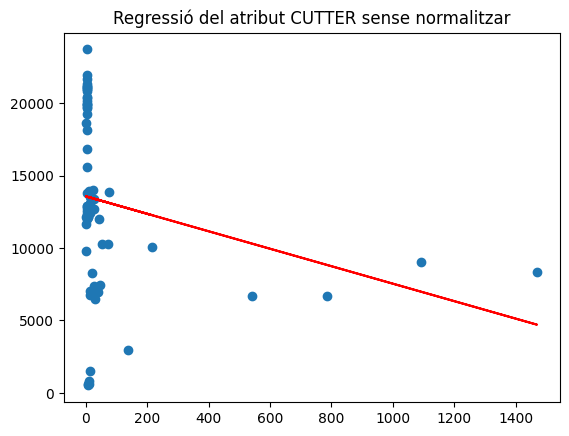

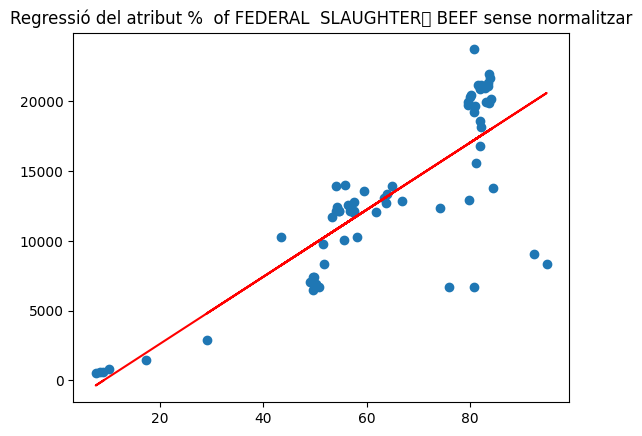

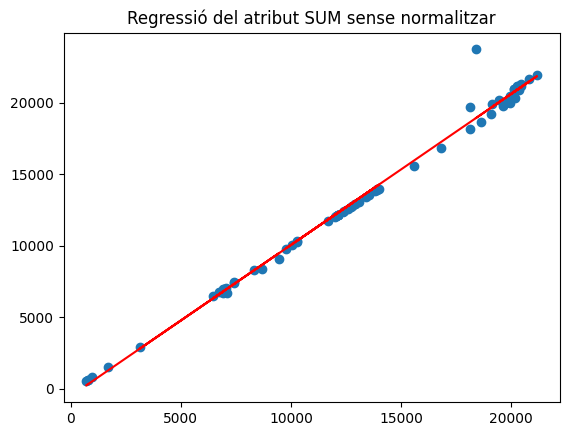

In [44]:
from sklearn.metrics import r2_score

# Extraiem el primer atribut de x i canviem la mida a #exemples, #dimensions de l'atribut.
# En el vostre cas, haureu de triar un atribut com a y, i utilitzar la resta com a x.
for index1 in range(x.shape[1]):
    atr = x[:,index1].reshape(x.shape[0], 1) 
    regr = regression(atr, y) 
    predicted = regr.predict(atr)

    # Mostrem la predicció del model entrenat en color vermell a la Figura anterior 1
    plt.figure()
    plt.title("Regressió del atribut {} sense normalitzar".format(index[index1]))
    ax = plt.scatter(x[:,index1], y)
    plt.plot(atr[:,0], predicted, 'r')

    # Mostrem l'error (MSE i R2)
    MSE = mse(y, predicted)
    r2 = r2_score(y, predicted)

    print("Mean squeared error ",index[index1],": ", MSE)
    print("R2 score: ", r2)


Amb estandarització

Mean squeared error  YEAR :  4605950.294898348
R2 score:  0.8778191593718119
Mean squeared error  POUNDS GRADED :  5.80261026716303e-25
R2 score:  1.0
Mean squeared error  PRIME :  21701983.512281522
R2 score:  0.4243171508458159
Mean squeared error  CHOICE :  8514741.790275076
R2 score:  0.7741316681554132
Mean squeared error  SELECT :  12769245.163558424
R2 score:  0.6612735682364921
Mean squeared error  STNDRD :  35771280.65717755
R2 score:  0.05110457968212667
Mean squeared error  COMRCL :  34175556.75569288
R2 score:  0.09343393089328511
Mean squeared error  UTILITY :  33798309.5722154
R2 score:  0.1034410684112359
Mean squeared error  CUTTER :  35478391.24225527
R2 score:  0.05887398070365746
Mean squeared error  %  of FEDERAL  SLAUGHTER	 BEEF :  12570033.243707657
R2 score:  0.666558010810152
Mean squeared error  SUM :  427224.7768383689
R2 score:  0.9886671199146203


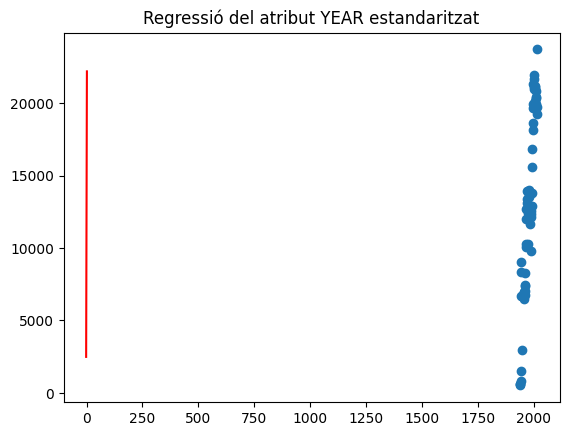

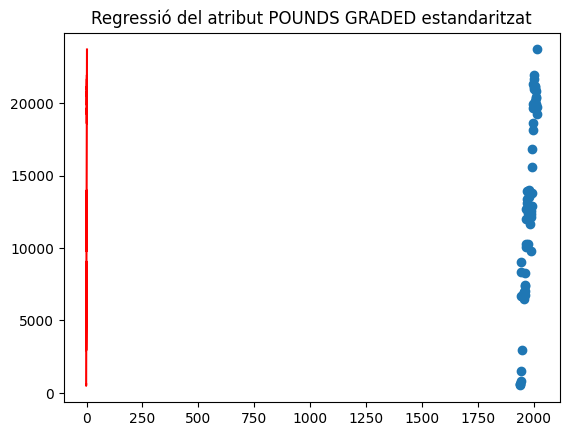

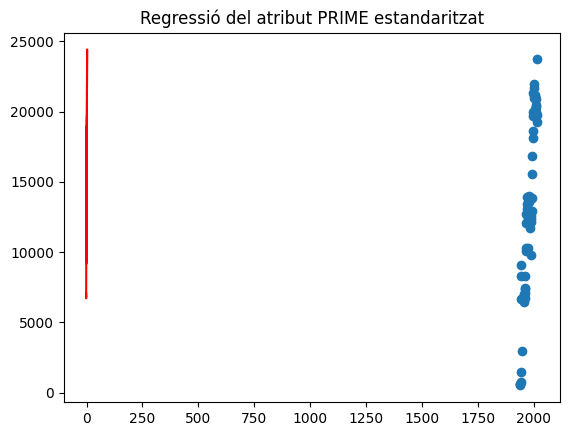

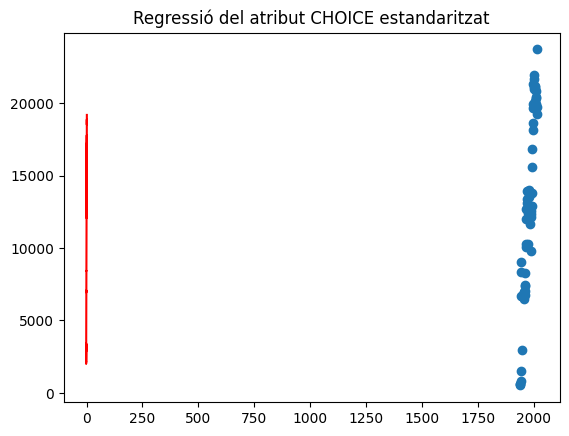

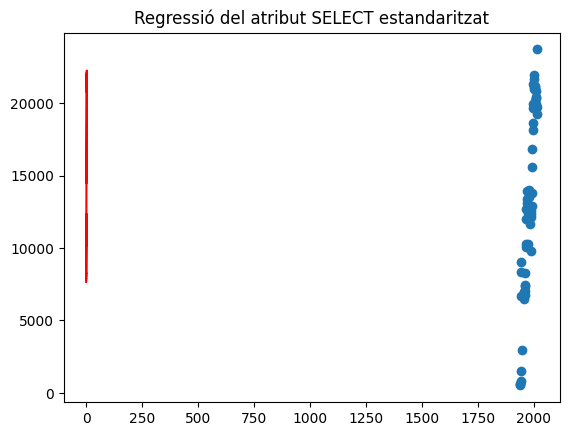

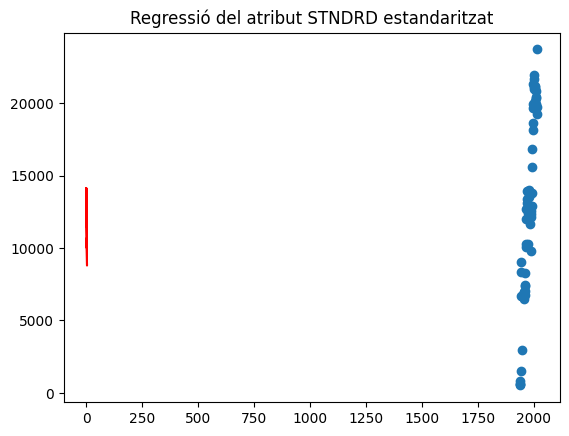

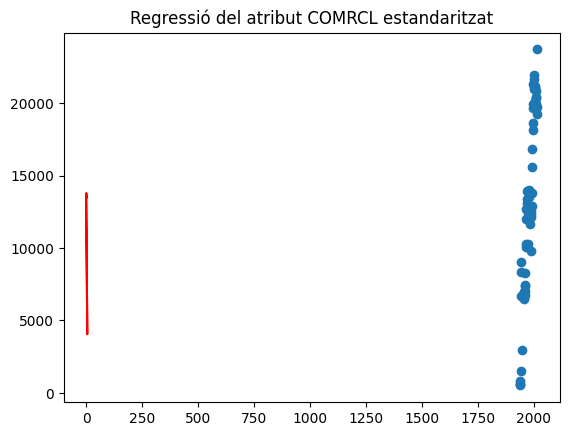

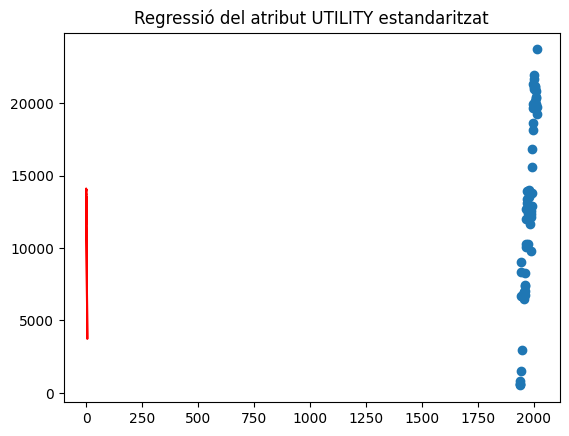

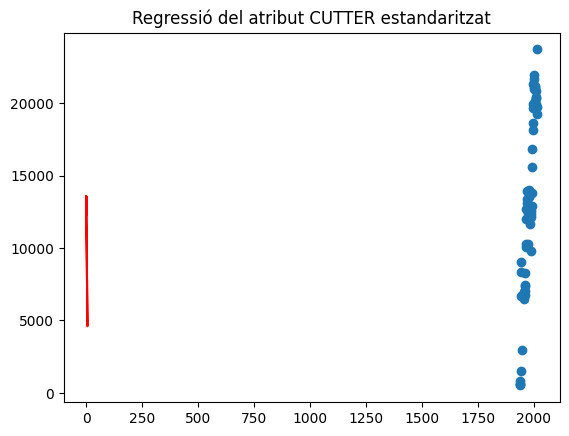

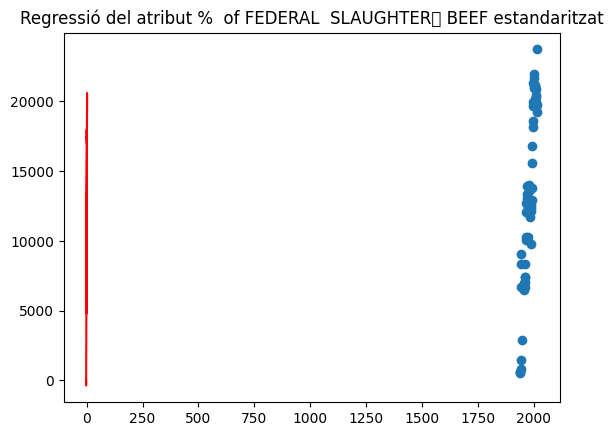

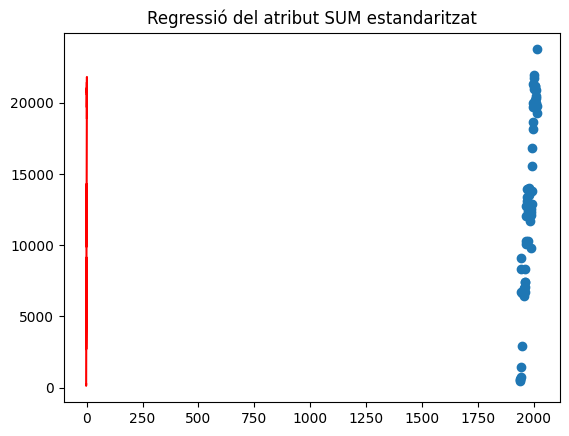

In [45]:
from sklearn.metrics import r2_score

# Extraiem el primer atribut de x i canviem la mida a #exemples, #dimensions de l'atribut.
# En el vostre cas, haureu de triar un atribut com a y, i utilitzar la resta com a x.
for index2 in range(xFill0.shape[1]):
    index1 = index2
    atribut1 = xFill0[:,index1].reshape(xFill0.shape[0], 1) 
    atribut1 = standarize(atribut1)
    regr = regression(atribut1, yFill0) 
    predicted = regr.predict(atribut1)

    # Mostrem la predicció del model entrenat en color vermell a la Figura anterior 1
    plt.figure()
    plt.title("Regressió del atribut {} estandaritzat".format(index[index1]))
    ax = plt.scatter(xFill0[:,0], yFill0)
    plt.plot(atribut1[:,0], predicted, 'r')

    # Mostrem l'error (MSE i R2)
    MSE = mse(yFill0, predicted)
    r2 = r2_score(yFill0, predicted)

    print("Mean squeared error ",index[index1],": ", MSE)
    print("R2 score: ", r2)

Mean squeared error  YEAR :  4605950.294898348
R2 score:  0.8778191593718119
Mean squeared error  POUNDS GRADED :  5.80261026716303e-25
R2 score:  1.0
Mean squeared error  PRIME :  25291940.622358546
R2 score:  0.32908729610461696
Mean squeared error  CHOICE :  8514741.790275076
R2 score:  0.7741316681554132
Mean squeared error  SELECT :  12769245.163558424
R2 score:  0.6612735682364921
Mean squeared error  STNDRD :  30286231.44144734
R2 score:  0.19660504780641253
Mean squeared error  COMRCL :  34623164.47696191
R2 score:  0.08156035776400195
Mean squeared error  UTILITY :  34261839.86500585
R2 score:  0.09114512138538611
Mean squeared error  CUTTER :  37580202.93352281
R2 score:  0.003119770857827997
Mean squeared error  %  of FEDERAL  SLAUGHTER	 BEEF :  12570033.243707657
R2 score:  0.666558010810152
Mean squeared error  SUM :  434495.04860945116
R2 score:  0.9884742633139814


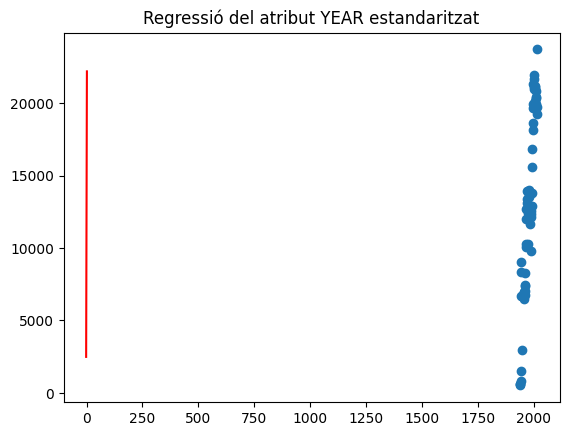

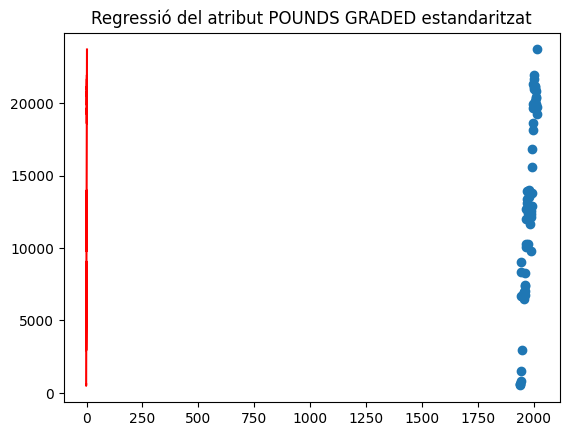

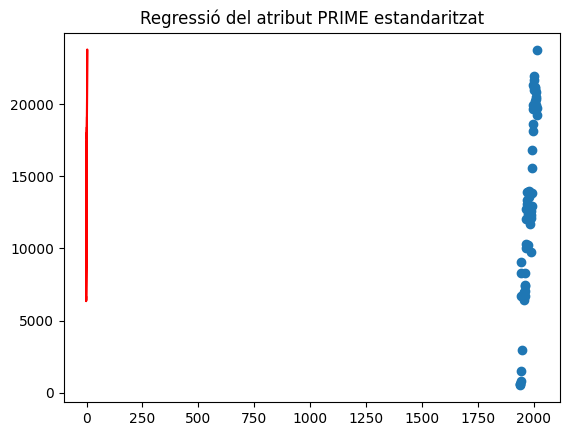

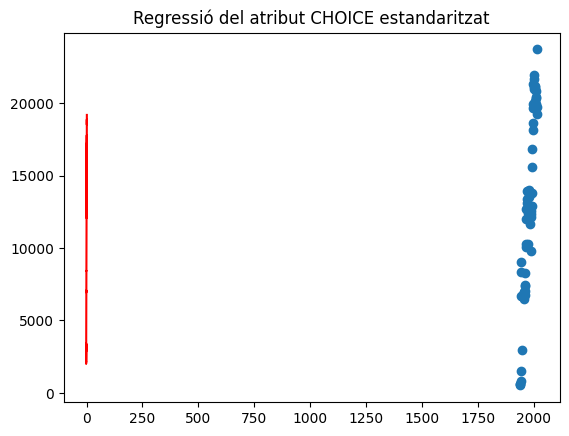

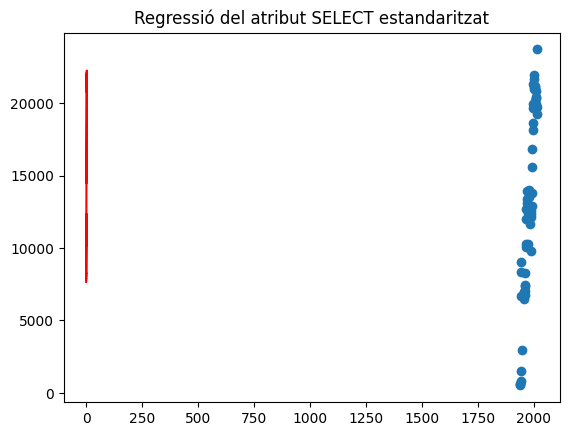

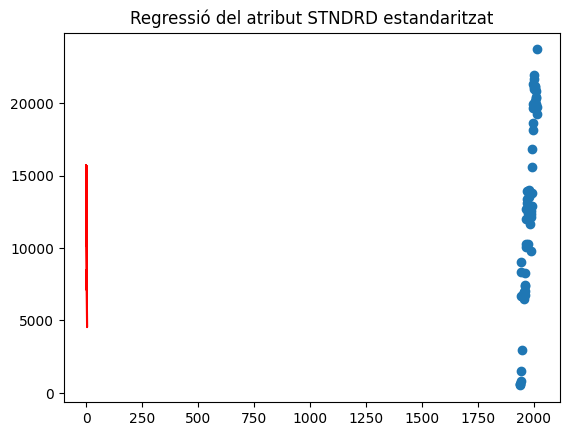

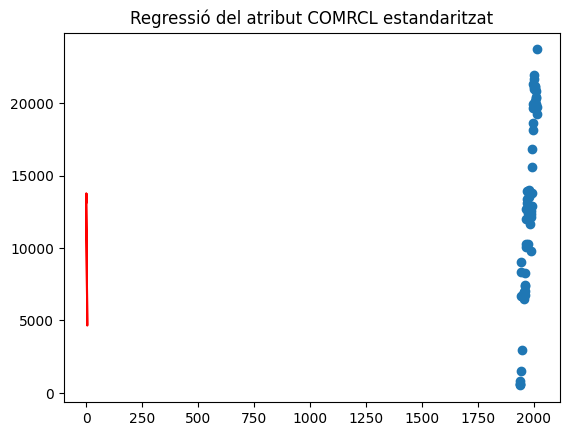

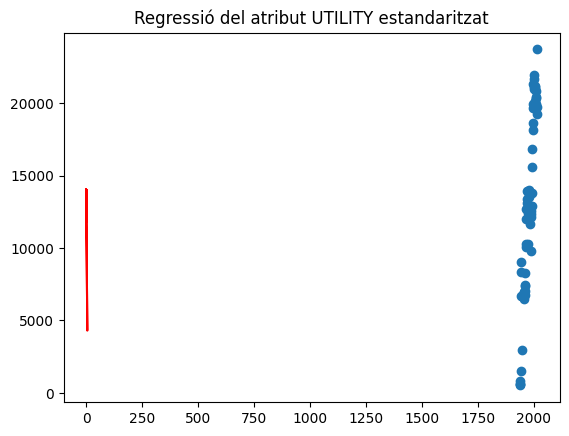

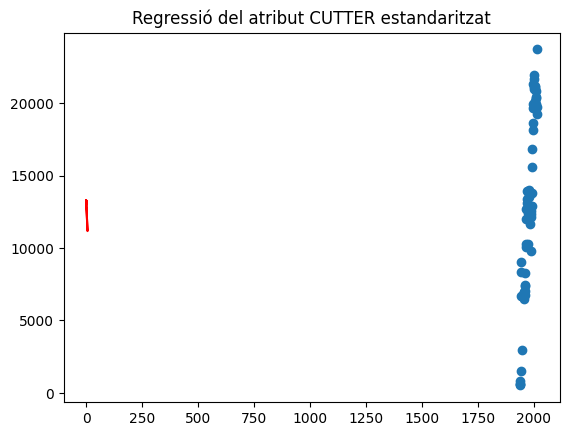

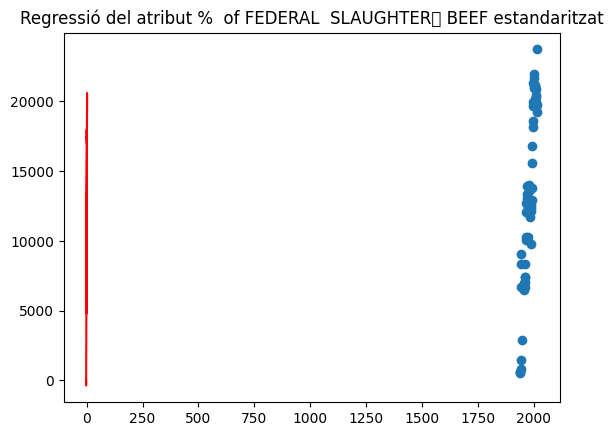

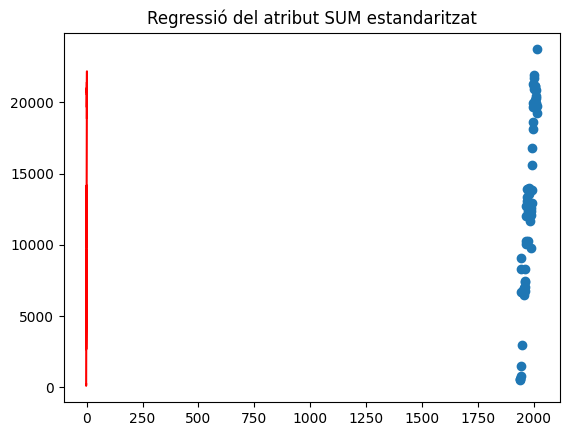

In [46]:
from sklearn.metrics import r2_score

# Extraiem el primer atribut de x i canviem la mida a #exemples, #dimensions de l'atribut.
# En el vostre cas, haureu de triar un atribut com a y, i utilitzar la resta com a x.
for index2 in range(xFillMean.shape[1]):
    index1 = index2
    atribut1 = xFillMean[:,index1].reshape(xFillMean.shape[0], 1) 
    atribut1 = standarize(atribut1)
    regr = regression(atribut1, yFillMean) 
    predicted = regr.predict(atribut1)

    # Mostrem la predicció del model entrenat en color vermell a la Figura anterior 1
    plt.figure()
    plt.title("Regressió del atribut {} estandaritzat".format(index[index1]))
    ax = plt.scatter(xFillMean[:,0], yFillMean)
    plt.plot(atribut1[:,0], predicted, 'r')

    # Mostrem l'error (MSE i R2)
    MSE = mse(yFillMean, predicted)
    r2 = r2_score(yFillMean, predicted)

    print("Mean squeared error ",index[index1],": ", MSE)
    print("R2 score: ", r2)

Mean squeared error  YEAR :  4605950.294898348
R2 score:  0.8778191593718119
Mean squeared error  POUNDS GRADED :  5.80261026716303e-25
R2 score:  1.0
Mean squeared error  PRIME :  21680954.936063554
R2 score:  0.42487497039553423
Mean squeared error  CHOICE :  8514741.790275076
R2 score:  0.7741316681554132
Mean squeared error  SELECT :  12769245.163558424
R2 score:  0.6612735682364921
Mean squeared error  STNDRD :  17366822.727031603
R2 score:  0.5393148288682794
Mean squeared error  COMRCL :  34179458.59450738
R2 score:  0.09333042783401835
Mean squeared error  UTILITY :  33808072.505900756
R2 score:  0.10318208961895603
Mean squeared error  CUTTER :  35535119.88188768
R2 score:  0.05736915489482075
Mean squeared error  %  of FEDERAL  SLAUGHTER	 BEEF :  12570033.243707657
R2 score:  0.666558010810152
Mean squeared error  SUM :  422696.96766775066
R2 score:  0.9887872279260513


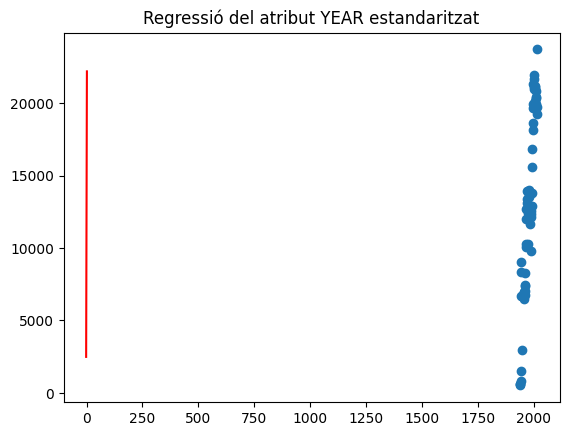

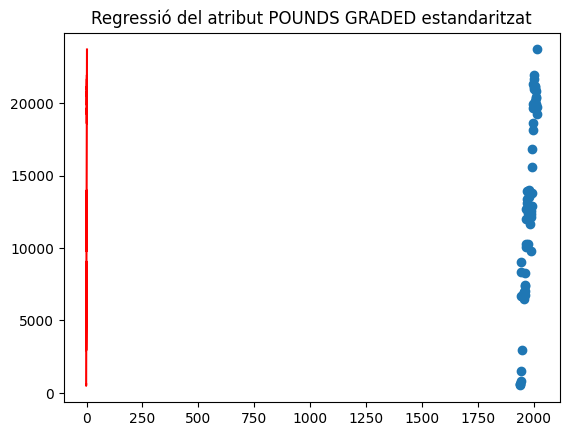

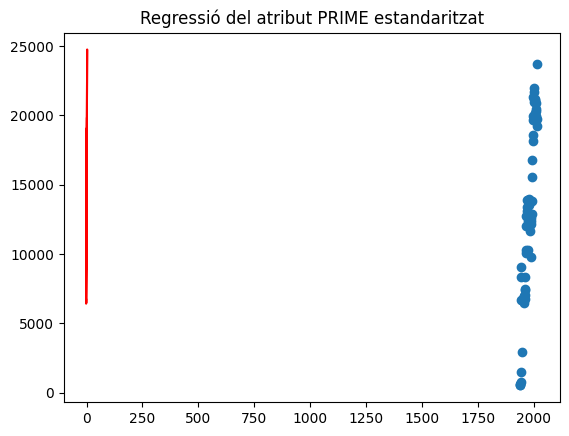

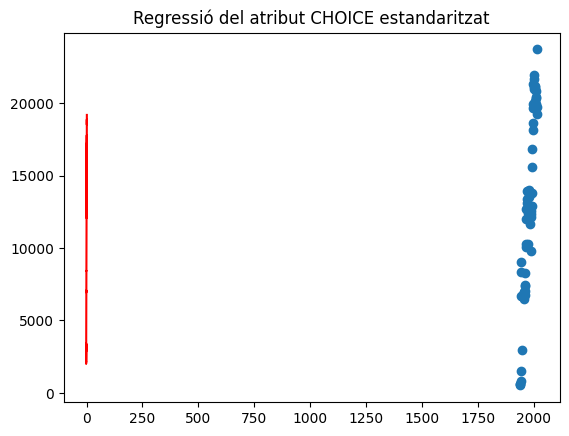

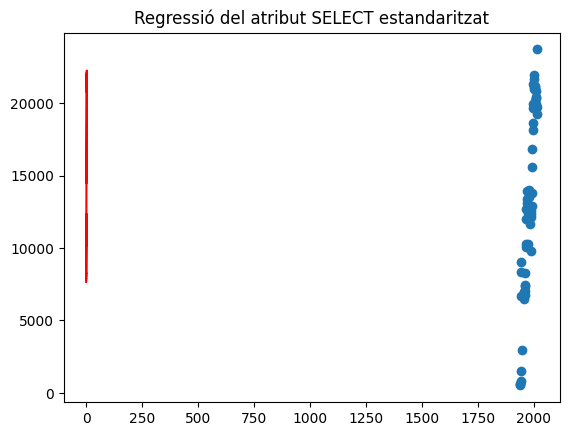

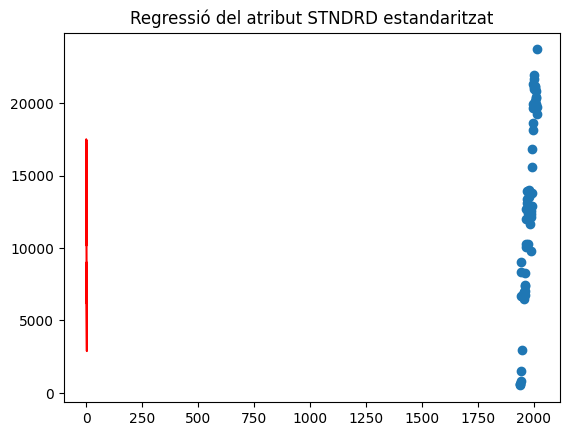

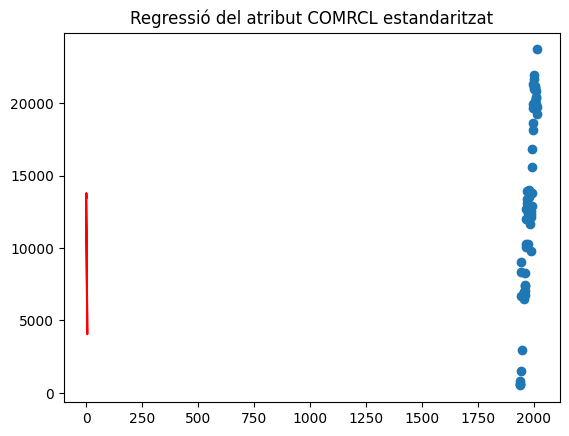

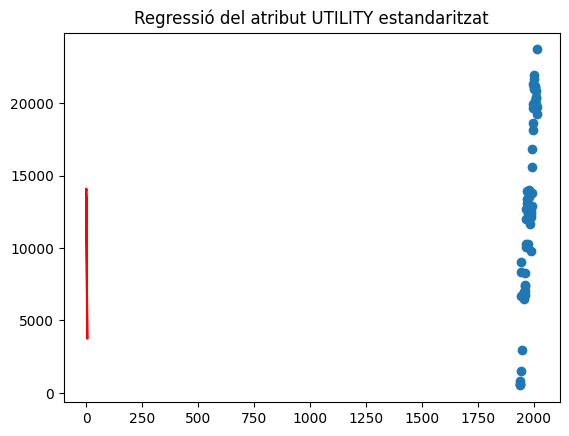

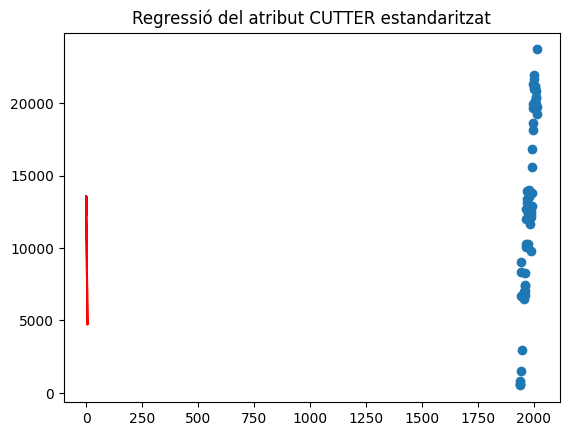

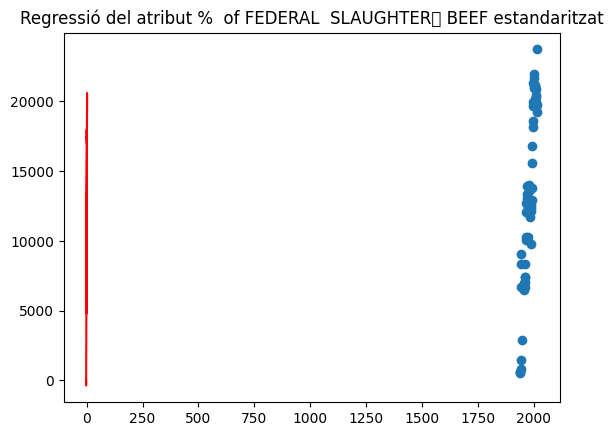

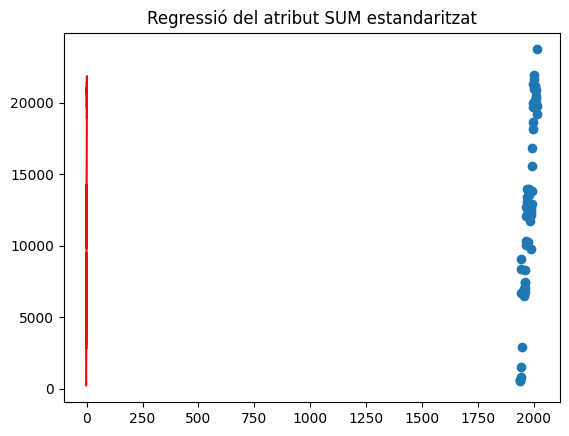

In [47]:
from sklearn.metrics import r2_score

# Extraiem el primer atribut de x i canviem la mida a #exemples, #dimensions de l'atribut.
# En el vostre cas, haureu de triar un atribut com a y, i utilitzar la resta com a x.
for index2 in range(x.shape[1]):
    index1 = index2
    atribut1 = x[:,index1].reshape(x.shape[0], 1) 
    atribut1 = standarize(atribut1)
    regr = regression(atribut1, y) 
    predicted = regr.predict(atribut1)

    # Mostrem la predicció del model entrenat en color vermell a la Figura anterior 1
    plt.figure()
    plt.title("Regressió del atribut {} estandaritzat".format(index[index1]))
    ax = plt.scatter(x[:,0], y)
    plt.plot(atribut1[:,0], predicted, 'r')

    # Mostrem l'error (MSE i R2)
    MSE = mse(y, predicted)
    r2 = r2_score(y, predicted)

    print("Mean squeared error ",index[index1],": ", MSE)
    print("R2 score: ", r2)

Un cop mostrats de manera adient, (en forma de taula, i/o de gràfics si la dimensionalitat ho permet) els resultats aconseguits amb la regressió, avaluarem de manera independent la idonietat de cadascun dels atributs.

Error en atribut 0: 4148387.721749
R2 score en atribut 0: 0.887778
Error en atribut 1: 0.000000
R2 score en atribut 1: 1.000000
Error en atribut 2: 25523450.818595
R2 score en atribut 2: 0.309539
Error en atribut 3: 10426801.749981
R2 score en atribut 3: 0.717934
Error en atribut 4: 14883426.677635
R2 score en atribut 4: 0.597373
Error en atribut 5: 15258152.878079
R2 score en atribut 5: 0.587236
Error en atribut 6: 36862943.336439
R2 score en atribut 6: 0.002783
Error en atribut 7: 36027675.856693
R2 score en atribut 7: 0.025378
Error en atribut 8: 38506133.886593
R2 score en atribut 8: -0.041669
Error en atribut 9: 12927880.365265
R2 score en atribut 9: 0.650275
Error en atribut 10: 1336214.811858
R2 score en atribut 10: 0.963853


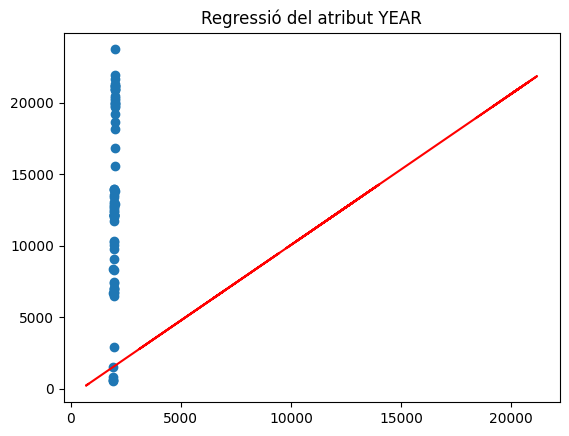

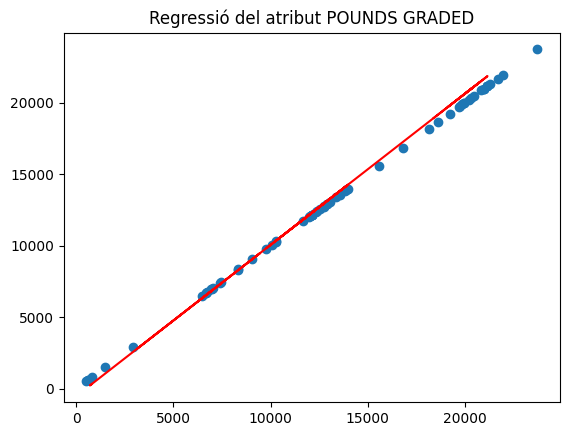

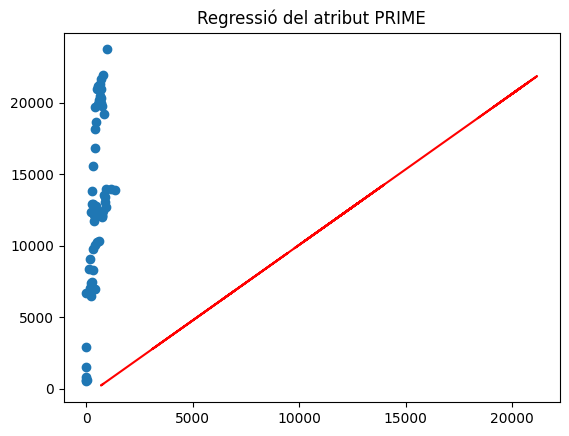

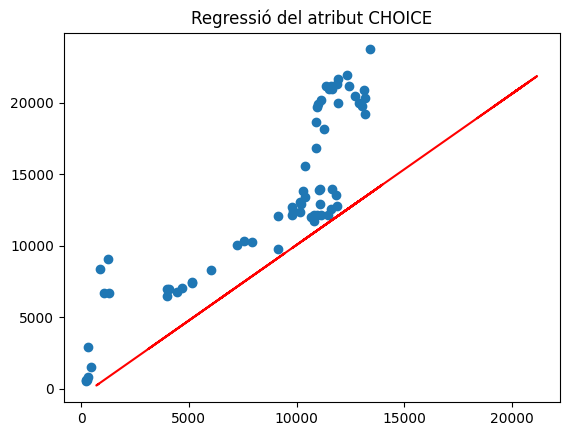

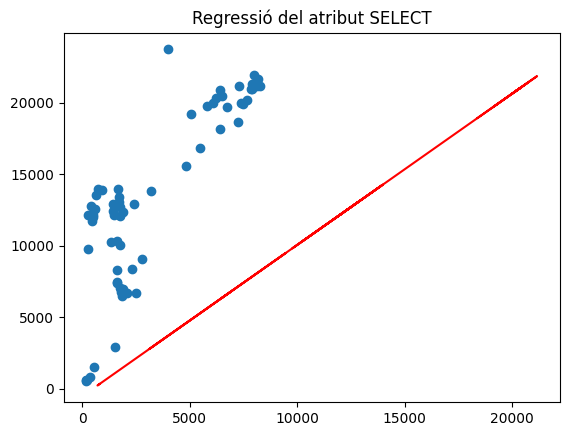

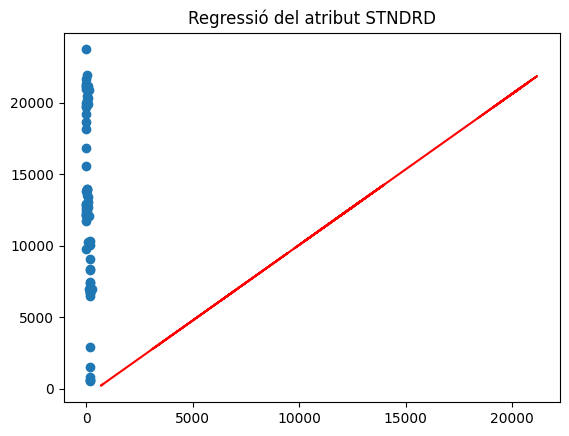

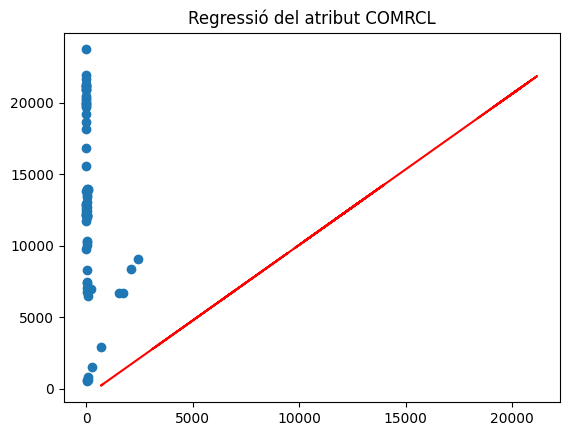

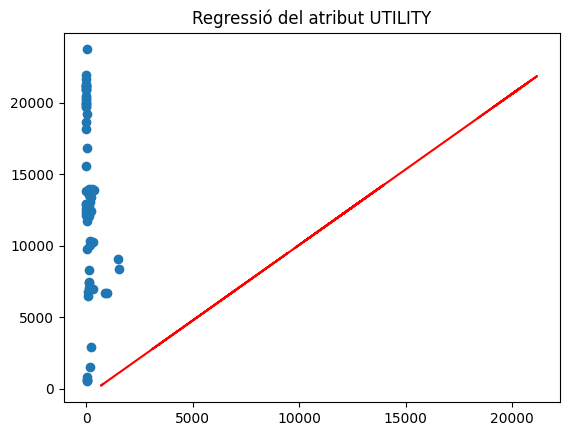

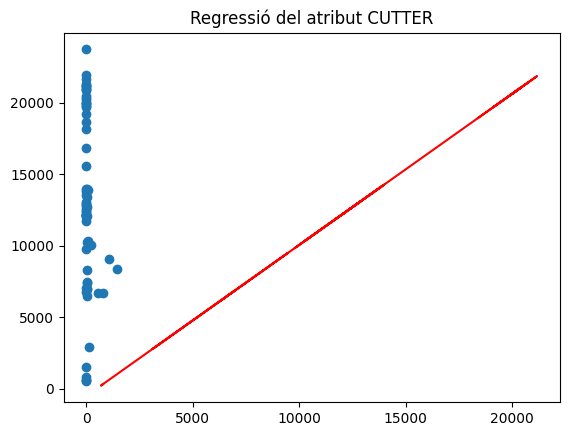

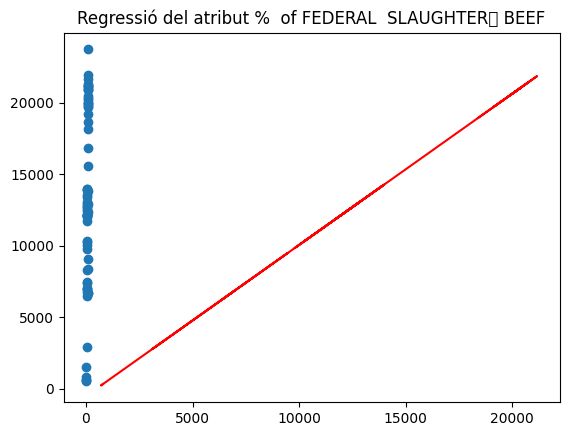

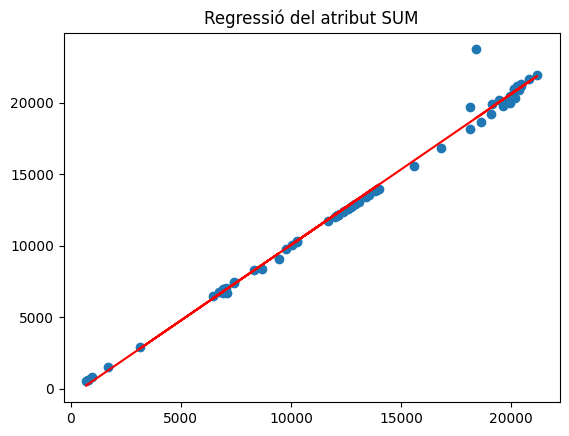

In [48]:
""" Per a assegurar-nos que el model s'ajusta be a dades noves, no vistes, 
cal evaluar-lo en un conjunt de validacio (i un altre de test en situacions reals).
Com que en aquest cas no en tenim, el generarem separant les dades en 
un 80% d'entrenament i un 20% de validació.
"""
def split_data(x, y, train_ratio=0.7):
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    n_train = int(np.floor(x.shape[0]*train_ratio))
    indices_train = indices[:n_train]
    indices_val = indices[n_train:] 
    x_train = x[indices_train, :]
    y_train = y[indices_train]
    x_val = x[indices_val, :]
    y_val = y[indices_val]
    return x_train, y_train, x_val, y_val

# Dividim dades d'entrenament
x_train, y_train, x_val, y_val = split_data(x, y)

for i in range(x_train.shape[1]):
    x_t = x_train[:,i] # seleccionem atribut i en conjunt de train
    x_v = x_val[:,i] # seleccionem atribut i en conjunt de val.
    x_t = np.reshape(x_t,(x_t.shape[0],1))
    x_v = np.reshape(x_v,(x_v.shape[0],1))

    regr = regression(x_t, y_train)    
    error = mse(y_val, regr.predict(x_v)) # calculem error
    r2 = r2_score(y_val, regr.predict(x_v))
    
    # Mostrem la predicció del model entrenat en color vermell a la Figura anterior 1
    plt.figure()
    plt.title("Regressió del atribut {}".format(index[i]))
    ax = plt.scatter(x[:,i], y)
    plt.plot(atr[:,0], predicted, 'r')

    print("Error en atribut %d: %f" %(i, error))
    print("R2 score en atribut %d: %f" %(i, r2))


Així es podrà contestar a aquestes **preguntes**:

1. Quin són els atributs més importants per fer una bona predicció?

2. Amb quin atribut s'assoleix un MSE menor?

3. Quina correlació hi ha entre els atributs de la vostra base de dades?

4. Com influeix la normalització en la regressió?

5. Com millora la regressió quan es filtren aquells atributs de les mostres que no contenen informació?

6. Si s'aplica un PCA, a quants components es redueix l'espai? Per què?


# Apartat (A): El descens del gradient  

En aquest exercici, es tracta d'implementar en python el procés de descent del gradient explicat a les classes de teoria, i comparar-lo amb els resultats obtinguts amb l'apartat (B). 

$$J(w) = \frac{1}{2m} \left[ \sum^m_{i=1}(f(x^{i}; w) - y^{i})^2 + \lambda\sum_{j=1}^{n}(w_{j}^2) \right]$$

Fixeu-vos que $J$ retorna el `mse`. Per a trobar $w_j$, repetir fins convergència:
$$w_0 = w_0 - \alpha \frac{1}{m} \sum_{i=1}^{m}(f(x^{i}; w)-y^{i}) \cdot 1$$
$$w_j = w_j - \alpha \left[\frac{1}{m} \sum_{i=1}^{m}(f(x^{i}; w)-y^{i}) \cdot x_{j}^{i} - \frac{\lambda}{m}w_{j} \right]$$


ó:

$$w_{j} := w_{j} \left(1-\alpha \frac{\lambda}{m} \right) - \alpha\frac{\lambda}{m} \sum_{i=1}^{m}(f(x^{i}; w)-y^{i}) \cdot x_{j}^{i}$$

On si considerem un regressor lineal (el model és una recta), llavors $w_0$ i $w_1$ representen, respectivament, la $b$ i $a$ de la fòrmula de la recta: 

$$h_\theta(x^{(i)}) = ax + b$$

$\alpha$ és el learning rate, i $h_\theta(x^{(i)})$ és la funció que fa la regressió, és a dir, la funció que prediu el valor de $y^{(i)}$ donat un(s) atribut(s) concret(s) $x^{(i)}$.

Així, tenint calculat el model en l'últim punt del primer exercici, ja sabeu quin resultat hauríeu d'obtenir. O no, perquè la vostra implementació pot ser millor! En concret, es tracta de desenvolupar aquestes tasques:

* Definir la funció de cost i del gradient

* Estudiar com l'ús de regularitzadors afecta el resultat: overfitting, underfitting, etc. 

* Visualització de les dades a analitzar i explicació pas a pas del procediment   

* Visualització del procés de descens de gradient 

* Modificar el learning rate i el nombre d'iteracions 

<img src="images/gradient_descent.png">

Per a la implementació us podeu basar en el següent esquelet:

In [49]:
class Regressor(object):
    def __init__(self, w0, w1, alpha):
        # Inicialitzem w0 i w1 (per ser ampliat amb altres w's)
        self.w0 = w0
        self.w1 = w1
        self.alpha = alpha

        
    def predict(self, x):
        # implementar aqui la funció de prediccio
        pass
    
    def __update(self, hy, y):
        # actualitzar aqui els pesos donada la prediccio (hy) i la y real.
        pass
    
    def train(self, max_iter, epsilon):
        # Entrenar durant max_iter iteracions o fins que la millora sigui inferior a epsilon
        pass

L'últim pas serà validar el regressor trobat pel descent del gradient desenvolupat en aquest apartat visualment, aplicat a un model de recta i un model de pla. Per a això, caldrà considerar el millor atribut identificat en el primer punt de l'anterior entrega per visualitzar la línia regressora en 2D (podeu mostrar dades 2d amb la funció scatter). Després, dos dels atributs identificats a l'últim punt del primer exercici per visualitzar el pla regressor en 3D (En el cas 3D l’scatter s’ha de fer sobre una figura amb projecció 3D).

<IPython.core.display.Javascript object>


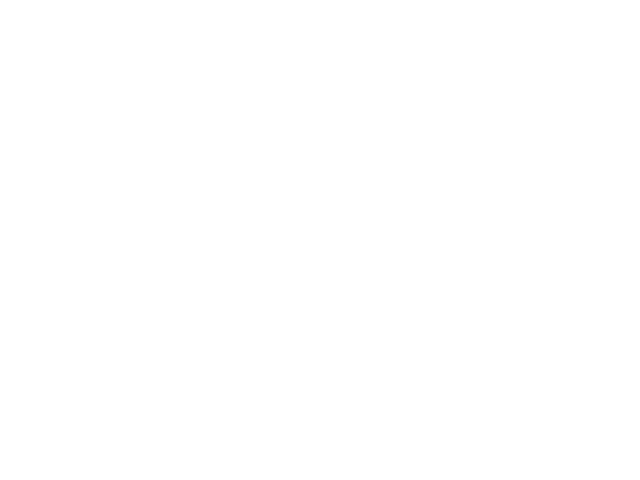

TypeError: gca() got an unexpected keyword argument 'projection'

In [50]:
%matplotlib notebook

# Creem figura 3d
from mpl_toolkits.mplot3d import axes3d, Axes3D
# generem dades 3D d'exemple
x_val = np.random.random((100, 2))
y_val = np.random.random((100, 1))
regr = regression(x_val, y_val)
predX3D = regr.predict(x_val)

# Afegim els 1's
A = np.hstack((x_val,np.ones([x_val.shape[0],1])))
w = np.linalg.lstsq(A,predX3D)[0]

#Dibuixem
#1r creem una malla acoplada a la zona de punts per tal de representar el pla
malla = (range(20) + 0 * np.ones(20)) / 10 
malla_x1 =  malla * (max(x_val[:,0]) - min(x_val[:,0]))/2 + min(x_val[:,0])
malla_x2 =  malla * (max(x_val[:,1]) - min(x_val[:,1]))/2 + min(x_val[:,1])

#la funcio meshgrid ens aparella un de malla_x1 amb un de malla_x2, per atot
#element de mallax_1 i per a tot element de malla_x2.
xplot, yplot = np.meshgrid(malla_x1 ,malla_x2)

# Cal desnormalitzar les dades
def desnormalitzar(x, mean, std):
    return x * std + mean

#ara creem la superficies que es un pla
zplot = w[0] * xplot + w[1] * yplot + w[2]

#Dibuixem punts i superficie
plt3d = plt.figure('Coeficiente prismatico -- Relacio longitud desplacament 3D', dpi=100.0).gca(projection='3d')
plt3d.plot_surface(xplot,yplot,zplot, color='red')
plt3d.scatter(x_val[:,0],x_val[:,1],y_val)

Així es podrà contestar a aquestes preguntes:

1. Com influeixen tots els paràmetres en el procés de descens? Quins valors de learning rate convergeixen més ràpid a la solució òptima? Com influeix la inicialització del model en el resultat final? 

2. Quines funcions polinomials (de diferent grau, de diferents combinacions d'atributs, ...) heu escollit per ser apreses amb el vostre descens del gradient? quina ha donat el millor resultat (en error i rapidesa en convergència)?

3. Utilitzeu el regularitzador en la fòrmula de funció de cost i descens del gradient i proveu polinomis de diferent grau. Com afecta el valor del regularitzador?

3. Quina diferència (quantitativa i qualitativa) hi ha entre el vostre regressor i el de la llibreria ?

4. Té sentit el model (polinomial) trobat quan es visualitza sobre les dades? 

5. Ajuda la visualització a identificar aquelles mostres per a les que el regressor obté els pitjors resultats de predicció? 
